In [2]:
using PorousMaterials # Pkg.clone("https://github.com/SimonEnsemble/PorousMaterials.jl", "v0.1.1")
using CSV
using DataFrames
using TSne
using PyCall
@pyimport adjustText
import PyPlot; const plt = PyPlot # now do plt.plt[:hist] for example
using DelimitedFiles
using LinearAlgebra
using Printf
using Random
using Optim
using ProgressMeter
using JLD2
using CoherentPointDrift # https://github.com/SimonEnsemble/CoherentPointDrift.jl

┌ Info: Precompiling CoherentPointDrift [f2ea4a43-f43b-53f6-b5b7-a2d2ad69993e]
└ @ Base loading.jl:1186


Cage database CDB41 (41 cages) from [here](https://github.com/marcinmiklitz/CDB41). Cleaned of solvent. Thanks to Kim Jelfs and M. Miklitz for kindly providing the cages.

Reference:
> M. Miklitz, S. Jiang, R. Clowes, M. E. Briggs, A. I. Cooper and K. E. Jelfs, Computational Screening of Porous Organic Molecules for Xenon/Krypton Separation, J. Phys. Chem. C, 2017. DOI: 10.1021/acs.jpcc.7b03848

Other set of 33 cages from the .xyz files deposited as ESI of DOI 10.1038/s41467-018-05271-9

> R. L. Greenaway, V. Santolini, M. J. Bennison, B. M. Alston, C. J. Pugh, M. A. Little, M. Miklitz, E. G. B. Eden-Rump, R. Clowes, A. Shakil, H. J. Cuthbertson, H. Armstrong, M. E. Briggs, K. E. Jelfs & A. I. Cooper. High-throughput discovery of organic cages and catenanes using computational screening fused with robotic synthesis. Nature Communications, 2018. DOI: 10.1038/s41467-018-05271-9
                                                              
I manually looked at Fig 4 in the main text and selected those that were synthesized. Some cages required visualization to compare to Fig 4 since e.g. there are multiple versions of B23, a few of which were apparently not synthesized but only computational predictions.

The `.xyz` files describing the molecular structure of all of these cages are in the directory `all_cages`.

In [3]:
cages = readdlm("all_cages/all_cages.txt")
cages[1]

"A11"

## Center and align cages for comparison
The center of mass will be set to be the origin.
Each cage will be rotated such that it is aligned with its principle moments of inertia.
i.e. the moment of inertia matrix of an "aligned" cage is diagonal.


First, a function to compute the center of mass of a group of `atoms` at Cartesian coordinates `x`, stored in the columns.

In [4]:
function center_of_mass(atoms::Array{Symbol, 1}, x::Array{Float64, 2})
    ams = read_atomic_masses()
    com = [0.0, 0.0, 0.0]
    total_mass = 0.0
    for (i, atom) in enumerate(atoms)
        com += ams[atom] * x[:, i]
        total_mass += ams[atom]
    end
    return com / total_mass
end

center_of_mass (generic function with 1 method)

A function to read in the raw `.xyz` file containing coordinates of a cage molecule, compute the center of mass, and translate the entire cage molecule such that its center of mass lays at the origin.

In [5]:
function centered_cage_coords(cage::AbstractString)
    # read in raw .xyz from `all_cages`
    atoms, x = read_xyz("all_cages/$cage.xyz")
    
    # compute center of mass
    x_com = center_of_mass(atoms, x)
    
    # shift coords so that cage is centered
    x = x .- x_com
    
    return atoms, x
end

centered_cage_coords (generic function with 1 method)

Next, a function to compute the moment of inertia matrix of a group of `atoms` at Cartesian positions `x`. 

See <a href="https://chem.libretexts.org/Textbook_Maps/Physical_and_Theoretical_Chemistry_Textbook_Maps/Map%3A_Physical_Chemistry_(McQuarrie_and_Simon)/13%3A_Molecular_Spectroscopy/13-08._The_Rotational_Spectrum_of_a_Polyatomic_Molecule_Depends_Upon_the_Principal_Moments_of_Inertia_of_the_Molecule">Chemistry Libre Texts</a> moment of inertia formulas.

In [6]:
function moment_of_inertia(atoms::Array{Symbol, 1}, x::Array{Float64, 2})
    @assert(isapprox(center_of_mass(atoms, x), [0.0, 0.0, 0.0], atol=0.0001),
        "cage must be centered to compute moment of inertia matrix!")
    
    # read in atomic masses
    ams = read_atomic_masses()
    
    # moment of inertia matrix `mi`
    mi = zeros(Float64, 3, 3)
    for i = 1:3
        for j = 1:3
            for (a, atom) in enumerate(atoms)
                if i == j
                    ids = collect(setdiff(Set([1, 2, 3]), Set([i])))
                    mi[i, j] += ams[atom] * sum(x[ids, a] .^ 2)
                else
                    mi[i, j] -= ams[atom] * x[i, a] * x[j, a]
                end
            end
        end
    end
    
    # should be symmetric!
    @assert isapprox(mi, mi')
        
    return mi
end

# simple test for diatomic molecule with atoms at [1, 0, 0], [-1, 0, 0]
@assert isapprox(
        moment_of_inertia([:C, :C], hcat([1.0, 0.0, 0.0], [-1.0, 0.0, 0.0])), 
        diagm(0 => [0.0, read_atomic_masses()[:C] / 2.0 * 4, read_atomic_masses()[:C] / 2.0 * 4]))
# simple test for a three-blade propeller. 
# see pg. 12 https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-07-dynamics-fall-2009/lecture-notes/MIT16_07F09_Lec26.pdf
@assert isapprox(
        moment_of_inertia([:O, :O, :O], 
                          hcat([0.0, 1.0, 0.0], [-sqrt(3)/2, -1/2, 0.0], [sqrt(3)/2, -1/2, 0.0])), 
        diagm(0 => read_atomic_masses()[:O] * [3/2, 3/2, 3.0]))
# a random rotation of the 3-blade propeller should have equal moments of inertia
_θ = rand() * 2 * π
_R = [cos(_θ) -sin(_θ); sin(_θ) cos(_θ)]
_x_2d = _R * hcat([0.0, 1.0], [-sqrt(3)/2, -1/2], [sqrt(3)/2, -1/2])
_x = vcat(_x_2d, [0.0 0.0 0.0])
_mi = moment_of_inertia([:O, :O, :O], _x)
@assert isapprox(_mi[1, 1], _mi[2, 2])

Now a function that calls the above functions to compute the moment of inertia matrix and then diagonalize it. i.e. find its eigendecomposition. This function returns an array of the eigenvalues `λ` of the moment of inertia, along with a matrix containing its eigenvectors `v`, as well as the moment of inertia matrix itself `mi`.

In [7]:
function diagonlize_moment_of_inertia(atoms::Array{Symbol, 1}, x::Array{Float64, 2})
    @assert(isapprox(center_of_mass(atoms, x), [0.0, 0.0, 0.0], atol=0.0001),
        "cage not centered!")
  
    # compute moment of inertia matrix
    mi = moment_of_inertia(atoms, x)

    # diagnomize moment of inertia matrix
    λ, v = eigen(mi) # columns of v are eigenvectors
    
    # reorder eigenvalues and eigenvectors from large to small
    ids = sortperm(λ, rev=true) # sort eigenvalues from large to small.
    λ = λ[ids]
    v = v[:, ids] # eigenvectors in columns
    
    # tests out of paranoia
    @assert(isapprox(mi * v, v * diagm(0 => λ)), "eigenvectors not right")
    @assert(isapprox([norm(v[:, i]) for i = 1:3], ones(3)), "eigenvectors not unit vectors")
    @assert(isapprox(mi, v * diagm(0 => λ) * v'))
    # `v` is a rotation matrix b/c `mi` is symmetric and the columns are orthonormal
    # i.e. `v` is a unitary matrix. now use it to rotate x to align with principle axes of rotation
    @assert(isapprox(v' * v, Diagonal{Float64}(I, 3)), "v is not unitary...")
    @assert (λ[1] >= λ[2]) & (λ[2] >= λ[3])
    
    return λ, v, mi
end

diagonlize_moment_of_inertia (generic function with 1 method)

function to center cage, then rotate it so as to align principle axes of inertia with the Cartesian axes.

In [8]:
function rotational_inertia_aligned_cage(cage::AbstractString)
    atoms, x = centered_cage_coords(cage)
    λ, v, mi = diagonlize_moment_of_inertia(atoms, x)
    
    # rotate cage so as to align it with the principle axes of inertia
    x = v' * x
    
    # now ensure its moment of inertia matrix is diagonal
    mi = moment_of_inertia(atoms, x)
    @assert(isapprox(diagm(0 => diag(mi)), mi), "not aligned with principle axes")

    # assert moments of inertia are ordered largest to smallest
    @assert(mi[1, 1] >= mi[2, 2])
    @assert(mi[2, 2] >= mi[3, 3])
    return atoms, x
end

rotational_inertia_aligned_cage (generic function with 1 method)

### Example where principal axes of inertia are degenerate.
SO$_3$ has degenerate moments of inertia and principal axes of inertia.
See [here](https://www.youtube.com/watch?v=7vt24ICeUag).

In [9]:
atoms_SO3 = [:S, :O, :O, :O]
ℓ_SO3 = 1.42 # bond length, A https://en.wikipedia.org/wiki/Sulfur_trioxide
x_SO3 = hcat([0.0, 0.0, 0.0], [-sqrt(3)/2*ℓ_SO3, -ℓ_SO3/2, 0.0], 
             [sqrt(3)/2*ℓ_SO3, -ℓ_SO3/2, 0.0], [0.0, ℓ_SO3, 0.0])
@assert isapprox(center_of_mass(atoms_SO3, x_SO3), zeros(3))
write_xyz(atoms_SO3, x_SO3, "SO3.xyz")
λ, v = eigen(moment_of_inertia(atoms_SO3, x_SO3))
println("λ of I(SO3) / ℓ_SO3^2 / m_O: ", λ / ℓ_SO3^2 / read_atomic_masses()[:O])

# see, any vector in x-y plane is an eigenvector!
x_rand = [rand(), rand(), 0.0] # random vector in x-y plane
@assert isapprox(moment_of_inertia(atoms_SO3, x_SO3) * x_rand, x_rand * λ[1])

λ of I(SO3) / ℓ_SO3^2 / m_O: [1.5, 1.5, 3.0]


#### Visualize moments of inertia about principal axes of inertia for every cage; write `.xyz` file of cages whose principal axes of inertia are aligned with the axes.

In [10]:
write_final_aligned_cage(atoms, x, cage) = write_xyz(atoms, x, "all_cages/" * cage * "_final_alignment.xyz")
aligned_and_centered_cage(cage::AbstractString) = read_xyz("all_cages/" * cage * "_final_alignment.xyz")

aligned_and_centered_cage (generic function with 1 method)

See [here](http://farside.ph.utexas.edu/teaching/336k/Newtonhtml/node67.html). The eigenvalues are the moments of inertia about the principle axes of rotation given by the eigenvectors. Let us visualize the eigenvalues among all of the cages.

We color consecutive bars if the difference in moments of inertia w.r.t. these principal axes are so small so as to be agnostic in which direction to align. We define small as: if a carbon atom is placed at the periphery of the cage on a different axes, would this change the ranking of the principal axes?

Keep track of cages where principal axes are agnostic in terms of which direction to align in `needs_further_alignment`. The rotational dynamics of some cages represent a sphere (`xyz`); others need aligned only in a certain plane (`yz` or `xy`).

... if methyl group throws off orientation
Cage B24 is robustly aligned using its principal axes of inertia
Cage B25 is robustly aligned using its principal axes of inertia
Cage C13 is robustly aligned using its principal axes of inertia
Cage C18 is robustly aligned using its principal axes of inertia
Cage C26 is robustly aligned using its principal axes of inertia
Cage CB6 is robustly aligned using its principal axes of inertia
Cage CB7 is robustly aligned using its principal axes of inertia
Cage CD1 is robustly aligned using its principal axes of inertia
Cage CP4 is robustly aligned using its principal axes of inertia
Cage CP5 is robustly aligned using its principal axes of inertia
Cage DC1 is robustly aligned using its principal axes of inertia
Cage IC2 is robustly aligned using its principal axes of inertia
Cage MC4 is robustly aligned using its principal axes of inertia
Cage MC7 is robustly aligned using its principal axes of inertia
Cage NC1 is robustly aligned using its principa

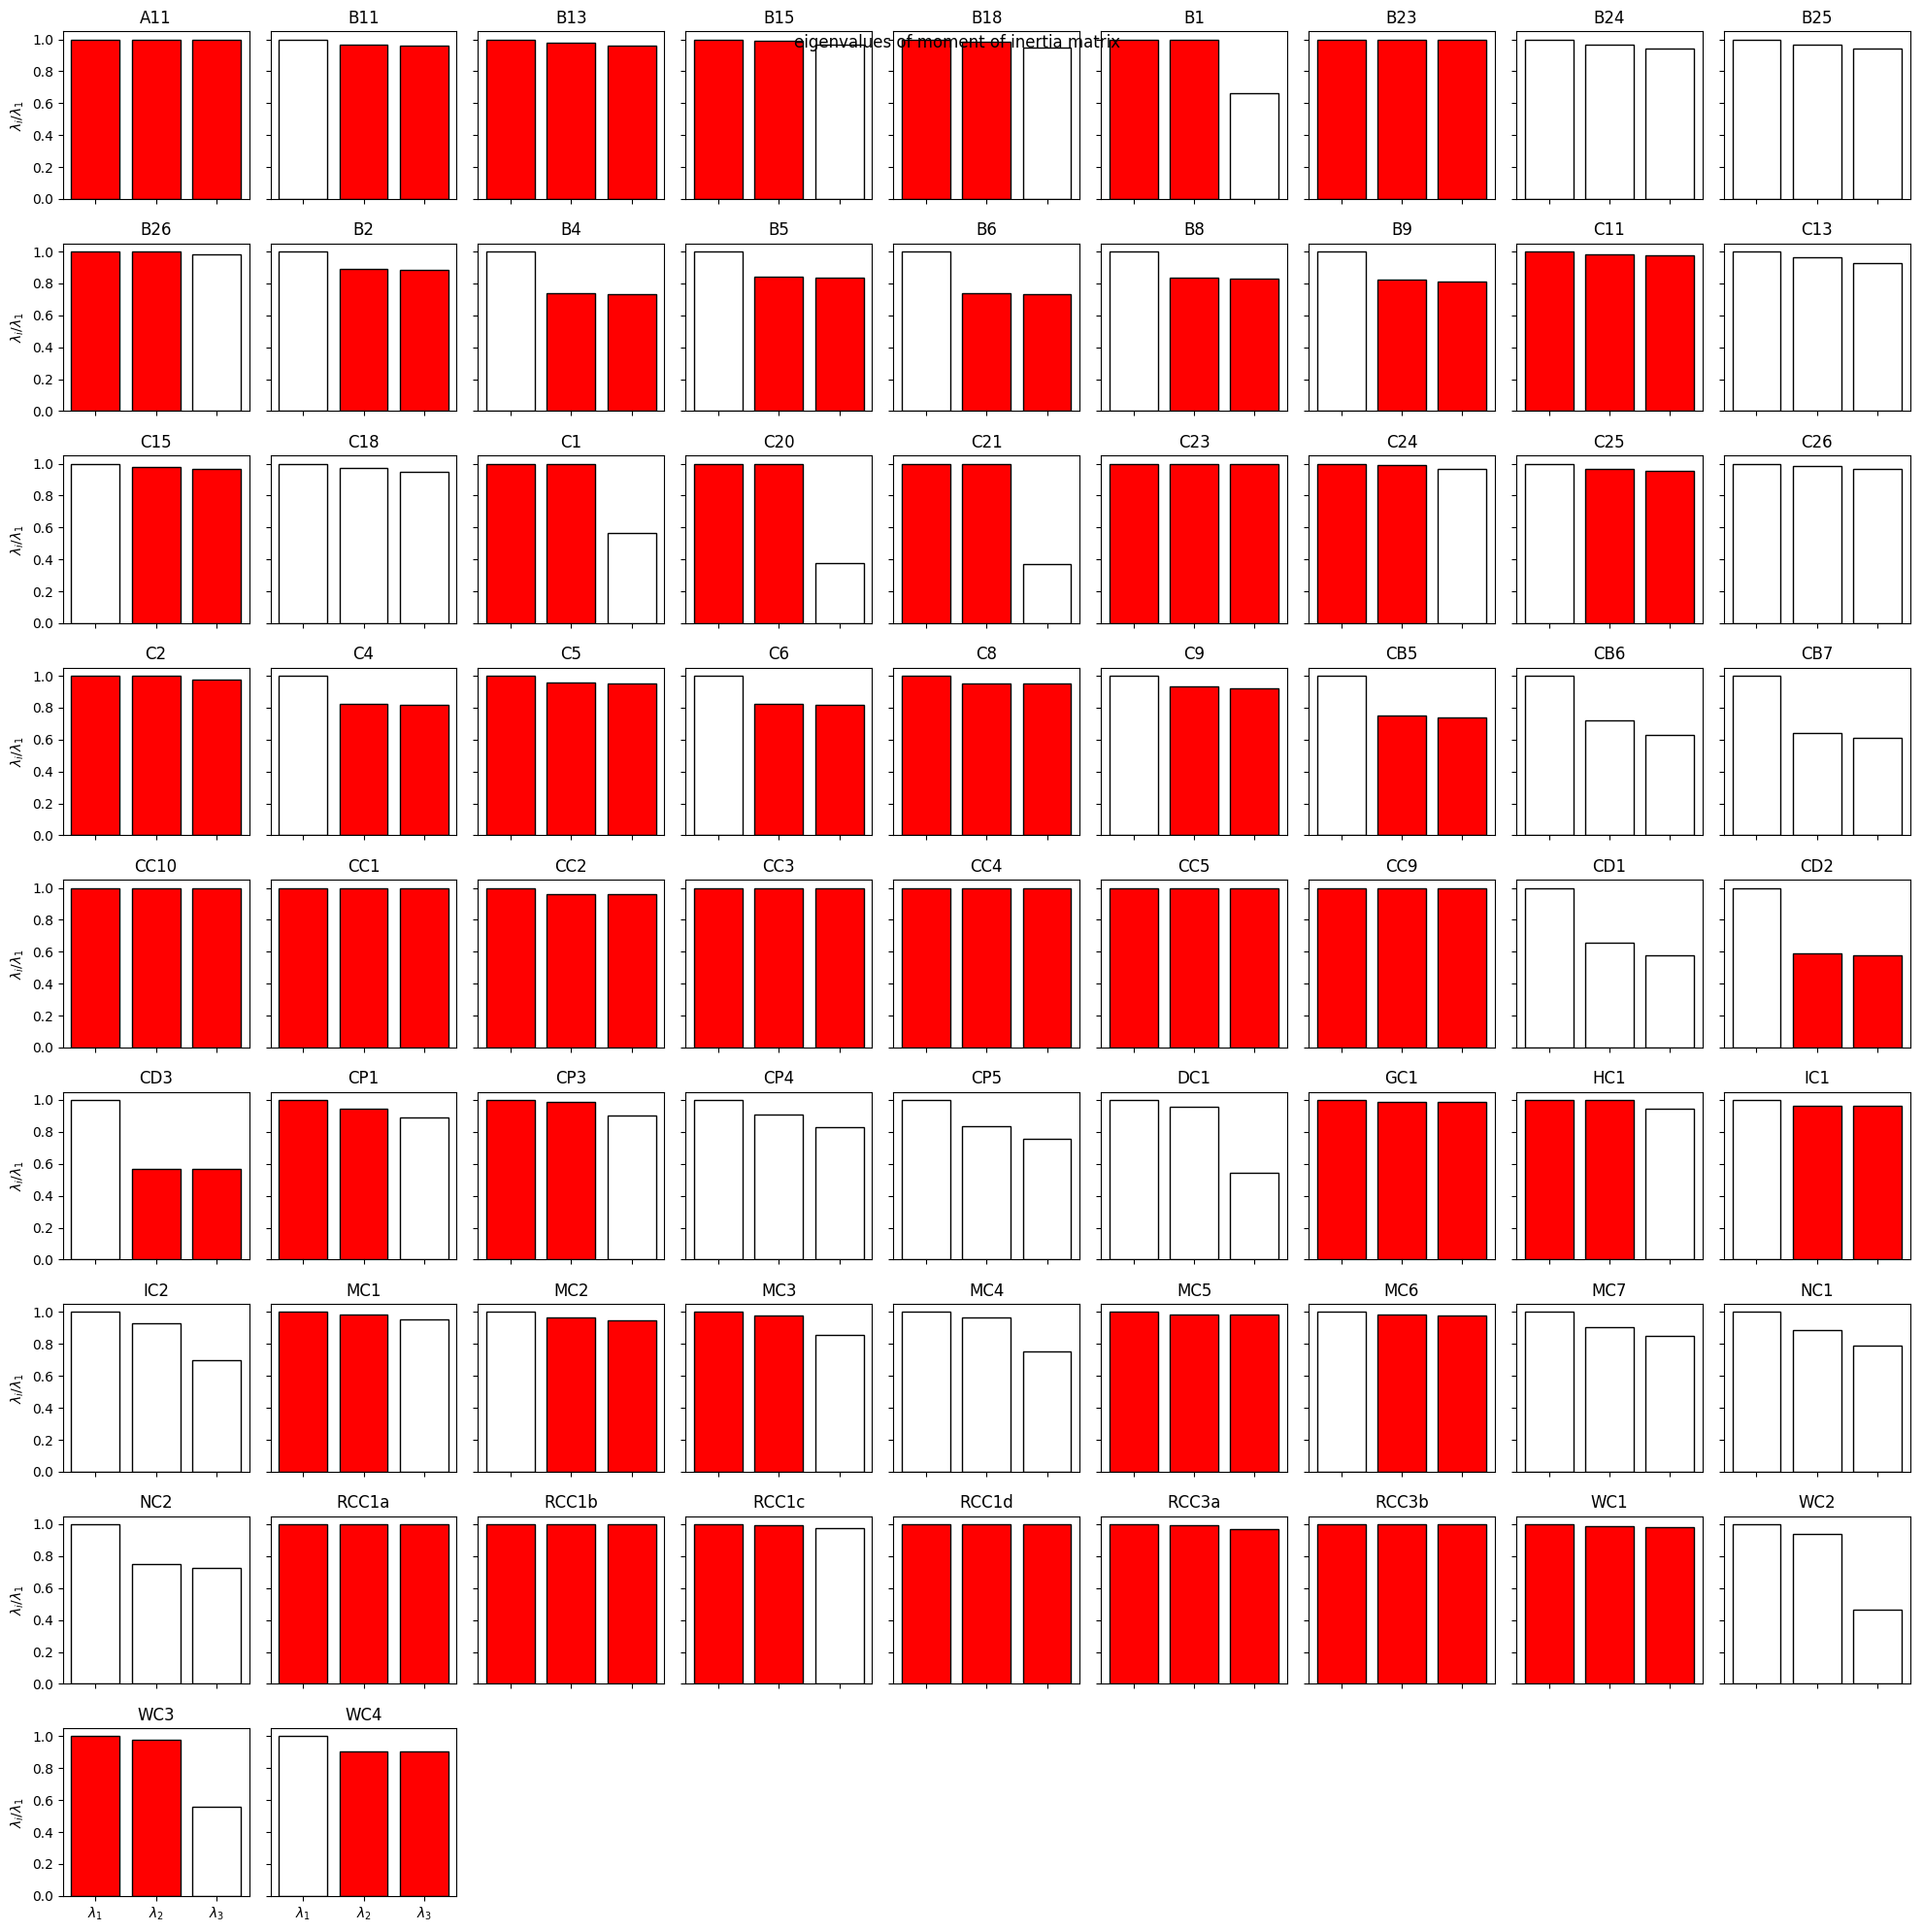

WC2 is robustly aligned using its principal axes of inertia


In [12]:
# list of cages that need alignment b/c principal axes of inertia agnostic
needs_further_alignment = Dict("xy" => String[], "yz" => String[], 
                               "xyz" => String[], "no" => String[])

printstyled("... if methyl group throws off orientation\n", color=:red)
nrows = ceil(Int, sqrt(length(cages))) # in the big plot
fig, axs = plt.subplots(nrows=nrows, ncols=nrows, figsize=(20, 20),
                          sharex=true, sharey=true)
cage_no = 0
for i = 1:nrows
    for j = 1:nrows
        cage_no += 1
        
        # blank panel if no cage for the panel
        if cage_no > length(cages)
            axs[i, j].axis("off")
            continue
        end
        
        # rotate cage so its principal axes of inertia aligned with Cartesian axes.
        atoms, x = rotational_inertia_aligned_cage(cages[cage_no])
        write_xyz(atoms, x, 
            "all_cages/" * cages[cage_no] * "_rotational_inertia_aligned.xyz")

        # compute new moment of inertia matrix to get moments of inertia
        #  about the princpal axes.
        λ, v, mi = diagonlize_moment_of_inertia(atoms, x)
        
        colorz = ["w", "w", "w"]
        
        # can a few e.g. C atoms at the periphery throw off the moment of inertia rankings?
        #  i.e. how sensitive is the alignment?
        cage_radius = maximum([norm(x[:, a]) for a = 1:size(x)[2]])
        Δλ_tol = 15.0 * cage_radius ^ 2
        xy_symmetry = isapprox(λ[1], λ[2], atol=Δλ_tol)
        yz_symmetry = isapprox(λ[2], λ[3], atol=Δλ_tol)
        if xy_symmetry && yz_symmetry
            push!(needs_further_alignment["xyz"], cages[cage_no])
            colorz[:] .= "r"
        elseif xy_symmetry
            push!(needs_further_alignment["xy"], cages[cage_no])
            colorz[1:2] .= "r"
        elseif yz_symmetry
            push!(needs_further_alignment["yz"], cages[cage_no])
            colorz[2:3] .= "r"
        else
            push!(needs_further_alignment["no"], cages[cage_no])
            @printf("Cage %s is robustly aligned using its principal axes of inertia\n", cages[cage_no])
            write_final_aligned_cage(atoms, x, cages[cage_no])
        end
       
        axs[i, j].bar([1, 2, 3], λ / λ[1], color=colorz, edgecolor="k")
        axs[i, j].set_title(cages[cage_no])
        if j == 1
            axs[i, j].set_ylabel("\$ \\lambda_i / \\lambda_1\$")
        end
    end
end
plt.xticks([1, 2, 3], ["\$\\lambda_1\$", "\$\\lambda_2\$", "\$\\lambda_3\$"])
plt.suptitle("eigenvalues of moment of inertia matrix")
plt.tight_layout()
plt.savefig("moments_of_inertia.pdf", format="pdf")
plt.show()

### Point set registration to align cages where principal axes of inertia were agnostic

i.e. cages present in `needs_further_alignment`.

This function, given a reference cage, searches among a list of given unaligned cages for the one with the best alignment using the Coherent Drift algorithm. Then it aligns the cage with the best alignment with the reference cage `ref_cage`.

#### Compute matrix of likelihoods to play with different methods

`ℓ[i, j]`: -ve log likelihood for transforming cage `i` to align with cage `j`.

In [13]:
ℓ = zeros(length(cages), length(cages)) # -ve log likelihood

@showprogress 1 "..." for i = 1:length(cages)
    _, y = centered_cage_coords(cages[i]) # y b/c we transform this one.
    for j = 1:length(cages)
        if i == j
            ℓ[i, j] = Inf
            continue
        end
        _, x = centered_cage_coords(cages[j])
        R, t, σ², ℓ[i, j] = CoherentPointDrift.rigid_point_set_registration(x, y, 
            w=0.0, σ²_tol=0.1, verbose=false, max_nb_em_steps=25)
    end
end

@save "ℓ_CPD.jld2" ℓ

	σ² = 0.526674, q = 177.912823, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01453 min
	σ² = 1.485975, q = 670.335415, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01523 min
	σ² = 9.093621, q = 1155.510730, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.01703 min
	σ² = 16.883863, q = 1481.157761, EM steps taken = 17, reason for exit: objective stopped decreasing, time: 0.01202 min
	σ² = 0.200000, q = 2019.443196, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00612 min
	σ² = 4.571589, q = 1011.040206, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01590 min
	σ² = 8.299411, q = 1373.610534, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02994 min
	σ² = 19.839876, q = 1865.553220, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03256 min
	σ² = 25.923231, q = 2606.890595, EM steps taken = 25, reason for exit: max EM steps reached, ti

...  1%|▋                                               |  ETA: 1:31:30

	σ² = 0.324549, q = 89.851190, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01240 min
	σ² = 0.959050, q = 474.812449, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01849 min
	σ² = 8.435518, q = 1134.039339, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01931 min
	σ² = 15.953013, q = 1454.759503, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.02025 min
	σ² = 0.200000, q = 1246.818198, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00760 min
	σ² = 3.948787, q = 999.646198, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01968 min
	σ² = 7.723469, q = 1357.589556, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03557 min
	σ² = 18.968751, q = 1841.698499, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03746 min
	σ² = 24.989377, q = 2580.750354, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.0440

...  3%|█▎                                              |  ETA: 1:36:18

	σ² = 0.419886, q = 172.636281, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01587 min
	σ² = 0.313751, q = -6.590276, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01919 min
	σ² = 7.971479, q = 1118.661430, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02431 min
	σ² = 16.394183, q = 1482.384645, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02546 min
	σ² = 0.200000, q = 1079.052171, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00947 min
	σ² = 3.617520, q = 985.425773, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02481 min
	σ² = 7.741411, q = 1362.902472, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03912 min
	σ² = 20.207056, q = 1892.749598, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04205 min
	σ² = 26.477745, q = 2642.023754, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05065 min
	σ

...  4%|██                                              |  ETA: 1:43:45

	σ² = 0.200000, q = 714.578176, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01644 min
	σ² = 0.200000, q = 1201.581444, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01992 min
	σ² = 0.200000, q = 1826.696594, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02533 min
	σ² = 5.475195, q = 989.421759, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02762 min
	σ² = 0.200000, q = 2480.620782, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01061 min
	σ² = 0.254357, q = 2753.021963, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02859 min
	σ² = 2.218327, q = 1062.174465, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04251 min
	σ² = 8.638909, q = 1534.066248, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04439 min
	σ² = 14.156515, q = 2255.521303, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05665 min
	σ

...  5%|██▋                                             |  ETA: 1:48:00

	σ² = 0.200000, q = 1477.181479, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01759 min
	σ² = 0.200000, q = 2245.454219, EM steps taken = 24, reason for exit: objective stopped decreasing, time: 0.02009 min
	σ² = 0.200000, q = 3753.457932, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02518 min
	σ² = 0.200000, q = 900.329831, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02639 min
	σ² = 0.200000, q = 3541.035574, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.01081 min
	σ² = 0.172881, q = 7506.109044, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02706 min
	σ² = 0.505127, q = 2881.591487, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04194 min
	σ² = 3.085233, q = 1356.224431, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04493 min
	σ² = 7.767520, q = 2047.162755, EM steps taken = 25, reason for exit: max EM steps reached, time

...  7%|███▎                                            |  ETA: 1:50:55

	σ² = 10.652766, q = 823.901140, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00671 min
	σ² = 11.598232, q = 1027.450503, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00783 min
	σ² = 11.498796, q = 1274.217362, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00926 min
	σ² = 23.206144, q = 1620.963286, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01004 min
	σ² = 32.919720, q = 1848.523453, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01108 min
	σ² = 15.307630, q = 1482.699498, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01112 min
	σ² = 20.844844, q = 1801.894407, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01925 min
	σ² = 34.769854, q = 2199.776068, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02481 min
	σ² = 40.861979, q = 2957.257649, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.027

...  8%|███▉                                            |  ETA: 1:40:14

	σ² = 0.079974, q = 3349.206581, EM steps taken = 16, reason for exit: variance below tol, time: 0.01120 min
	σ² = 0.468054, q = 784.142172, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02150 min
	σ² = 0.978979, q = 805.517798, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02648 min
	σ² = 5.942915, q = 1094.450233, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02755 min
	σ² = 12.889728, q = 1404.864691, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02689 min
	σ² = 0.200000, q = 1155.995877, EM steps taken = 23, reason for exit: objective stopped decreasing, time: 0.00942 min
	σ² = 3.596059, q = 907.031578, EM steps taken = 24, reason for exit: objective stopped decreasing, time: 0.04237 min
	σ² = 13.927542, q = 1643.730996, EM steps taken = 22, reason for exit: objective stopped decreasing, time: 0.04057 min
	σ² = 20.024508, q = 2395.529424, EM steps taken = 19, reason for exit: objective stopped d

...  9%|████▌                                           |  ETA: 1:41:38

	σ² = 0.524916, q = 624.348191, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01884 min
	σ² = 1.218327, q = 629.707857, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02241 min
	σ² = 0.855930, q = 901.096489, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02797 min
	σ² = 2.563236, q = 925.967651, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02970 min
	σ² = 6.771691, q = 1198.152378, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03066 min
	σ² = 0.200000, q = 1690.210673, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01136 min
	σ² = 0.200000, q = 553.515057, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02994 min
	σ² = 8.107982, q = 1360.065986, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04699 min
	σ² = 13.728814, q = 2120.600140, EM steps taken = 23, reason for exit: objective stopped decreasing, time: 0.05375 m

... 11%|█████▎                                          |  ETA: 1:43:25

	σ² = 0.005976, q = 88186.081305, EM steps taken = 15, reason for exit: variance below tol, time: 0.01271 min
	σ² = 0.308915, q = 1746.136447, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02514 min
	σ² = 0.055333, q = 16455.295540, EM steps taken = 3, reason for exit: variance below tol, time: 0.00414 min
	σ² = 0.948124, q = 1105.078974, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03265 min
	σ² = 2.374916, q = 1056.504173, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04679 min
	σ² = 0.200000, q = 3165.583636, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01234 min
	σ² = 0.200000, q = 1611.607152, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03257 min
	σ² = 0.200000, q = 1244.866932, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.04788 min
	σ² = 4.188200, q = 1349.928917, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 

... 12%|█████▉                                          |  ETA: 1:45:53

	σ² = 0.200000, q = 1857.212784, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02614 min
	σ² = 0.200000, q = 2202.591800, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03162 min
	σ² = 0.200000, q = 4133.539334, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05075 min
	σ² = 1.882189, q = 956.052071, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05264 min
	σ² = 2.754063, q = 1028.158855, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05383 min
	σ² = 0.200000, q = 3016.510747, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01565 min
	σ² = 0.200000, q = 1806.264964, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05284 min
	σ² = 0.200000, q = 1407.462025, EM steps taken = 18, reason for exit: objective stopped decreasing, time: 0.04190 min
	σ² = 0.200000, q = 503.351978, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06193

... 14%|██████▌                                         |  ETA: 1:51:12

	σ² = 10.551757, q = 822.434248, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00783 min
	σ² = 11.494599, q = 1025.719582, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00937 min
	σ² = 11.398536, q = 1271.973418, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01164 min
	σ² = 23.083156, q = 1619.014843, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01194 min
	σ² = 32.795003, q = 1846.957955, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01012 min
	σ² = 0.200000, q = -224.306429, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00128 min
	σ² = 15.215928, q = 1481.015966, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00976 min
	σ² = 20.734330, q = 1799.807650, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01778 min
	σ² = 34.643917, q = 2197.927093, EM steps taken = 25, reason for exit: max EM steps reached, time:

... 15%|███████▏                                        |  ETA: 1:43:58

	σ² = 6.174003, q = 727.337791, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00866 min
	σ² = 6.381882, q = 893.162597, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01049 min
	σ² = 6.595483, q = 1120.613746, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01305 min
	σ² = 13.416136, q = 1410.660069, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01420 min
	σ² = 20.865071, q = 1644.929171, EM steps taken = 23, reason for exit: objective stopped decreasing, time: 0.01308 min
	σ² = 0.094399, q = -39.656698, EM steps taken = 4, reason for exit: variance below tol, time: 0.00096 min
	σ² = 8.758854, q = 1310.572999, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01445 min
	σ² = 11.736525, q = 1567.917144, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02442 min
	σ² = 22.512863, q = 1965.346599, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02769

... 16%|███████▊                                        |  ETA: 1:39:15

	σ² = 7.008242, q = 733.980845, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00799 min
	σ² = 7.453591, q = 905.249443, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00978 min
	σ² = 7.780380, q = 1144.640141, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01205 min
	σ² = 17.089944, q = 1484.089293, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01246 min
	σ² = 25.975410, q = 1729.914636, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01308 min
	σ² = 0.051724, q = -106.353678, EM steps taken = 4, reason for exit: variance below tol, time: 0.00091 min
	σ² = 10.718952, q = 1347.193913, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01250 min
	σ² = 15.091360, q = 1646.854669, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02332 min
	σ² = 27.766665, q = 2066.509650, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02528 min
	

... 18%|████████▍                                       |  ETA: 1:34:43

	σ² = 6.520442, q = 723.637384, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00899 min
	σ² = 7.000622, q = 899.042902, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01079 min
	σ² = 7.246354, q = 1133.057506, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01328 min
	σ² = 14.698417, q = 1436.611113, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01411 min
	σ² = 22.375100, q = 1671.234787, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01450 min
	σ² = 0.058364, q = -94.640326, EM steps taken = 4, reason for exit: variance below tol, time: 0.00105 min
	σ² = 9.688920, q = 1327.742855, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01401 min
	σ² = 12.978593, q = 1597.958001, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02416 min
	σ² = 23.897941, q = 1993.928351, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02738 min
	σ²

... 19%|█████████▏                                      |  ETA: 1:31:02

	σ² = 7.104618, q = 733.289504, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00801 min
	σ² = 7.742813, q = 913.664398, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01018 min
	σ² = 7.999319, q = 1151.303495, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01269 min
	σ² = 17.612582, q = 1494.788343, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01255 min
	σ² = 26.704472, q = 1742.247738, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01422 min
	σ² = 0.046343, q = -86.844486, EM steps taken = 4, reason for exit: variance below tol, time: 0.00091 min
	σ² = 11.067538, q = 1356.855828, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01261 min
	σ² = 15.573833, q = 1658.654465, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02194 min
	σ² = 28.521937, q = 2080.951752, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02628 min
	σ

... 20%|█████████▊                                      |  ETA: 1:27:30

	σ² = 7.665601, q = 746.977965, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00893 min
	σ² = 8.354536, q = 930.693126, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01217 min
	σ² = 8.536812, q = 1168.643251, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01367 min
	σ² = 18.756742, q = 1521.284706, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01339 min
	σ² = 28.100617, q = 1767.172218, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01333 min
	σ² = 0.059073, q = -101.501349, EM steps taken = 4, reason for exit: variance below tol, time: 0.00088 min
	σ² = 11.887384, q = 1381.365347, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01285 min
	σ² = 16.672006, q = 1689.761409, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02260 min
	σ² = 29.926347, q = 2108.994375, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02558 min
	

... 22%|██████████▍                                     |  ETA: 1:24:07

	σ² = 0.376708, q = 95.072926, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01585 min
	σ² = 0.200000, q = -441.088337, EM steps taken = 11, reason for exit: objective stopped decreasing, time: 0.00836 min
	σ² = 0.832517, q = 466.828817, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02327 min
	σ² = 6.745877, q = 1054.950774, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02650 min
	σ² = 13.672479, q = 1390.190350, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02583 min
	σ² = 0.200000, q = 1225.572954, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00913 min
	σ² = 2.985919, q = 955.537664, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02485 min
	σ² = 5.302860, q = 1230.222213, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03996 min
	σ² = 16.184970, q = 1759.419768, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04185

... 23%|███████████                                     |  ETA: 1:23:17

	σ² = 0.428852, q = 142.021901, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01826 min
	σ² = 0.116700, q = 563.673017, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02267 min
	σ² = 0.456091, q = 307.777089, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02689 min
	σ² = 6.380388, q = 1035.140645, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02830 min
	σ² = 14.006626, q = 1411.696948, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02980 min
	σ² = 0.200000, q = 712.096154, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01090 min
	σ² = 2.698464, q = 894.050651, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02866 min
	σ² = 6.109588, q = 1254.215857, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04391 min
	σ² = 17.223635, q = 1800.044721, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04643 min
	σ² 

... 24%|███████████▋                                    |  ETA: 1:23:04

	σ² = 0.200000, q = 855.075638, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01911 min
	σ² = 0.200000, q = 1013.749722, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02331 min
	σ² = 0.200000, q = 2210.718168, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02844 min
	σ² = 0.370426, q = 168.191126, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03114 min
	σ² = 3.874186, q = 864.379600, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03113 min
	σ² = 0.200000, q = 2292.465870, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01156 min
	σ² = 0.491026, q = 1403.525093, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03029 min
	σ² = 2.454409, q = 1108.076486, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04485 min
	σ² = 5.516578, q = 1384.683762, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04807 min
	σ² 

... 26%|████████████▍                                   |  ETA: 1:22:53

	σ² = 0.200000, q = 1414.255769, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01959 min
	σ² = 0.200000, q = 1801.837784, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02399 min
	σ² = 0.200000, q = 3522.725412, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03576 min
	σ² = 0.200000, q = 852.289438, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03657 min
	σ² = 0.655552, q = 210.037536, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03731 min
	σ² = 0.200000, q = 3046.033693, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01198 min
	σ² = 0.092324, q = 13196.997632, EM steps taken = 3, reason for exit: variance below tol, time: 0.00430 min
	σ² = 0.971864, q = 1410.657408, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04632 min
	σ² = 2.853660, q = 1256.065541, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04930 min
	σ² =

... 27%|█████████████                                   |  ETA: 1:22:29

	σ² = 9.647993, q = 804.203296, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00749 min
	σ² = 10.554884, q = 1003.684223, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00927 min
	σ² = 10.441519, q = 1243.766822, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01142 min
	σ² = 22.059204, q = 1605.336675, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01184 min
	σ² = 31.800439, q = 1838.408277, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01242 min
	σ² = 0.200000, q = -222.490618, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00164 min
	σ² = 14.066118, q = 1454.582014, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01203 min
	σ² = 19.613099, q = 1779.904321, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02130 min
	σ² = 33.490994, q = 2184.937576, EM steps taken = 25, reason for exit: max EM steps reached, time: 

... 28%|█████████████▋                                  |  ETA: 1:19:21

	σ² = 9.720200, q = 833.873112, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00736 min
	σ² = 10.488051, q = 1034.106924, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00895 min
	σ² = 10.528828, q = 1292.082952, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01102 min
	σ² = 21.838990, q = 1630.589344, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01150 min
	σ² = 30.295078, q = 1828.893307, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01199 min
	σ² = 0.049323, q = 1159.424798, EM steps taken = 12, reason for exit: variance below tol, time: 0.00229 min
	σ² = 13.238546, q = 1460.710063, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01171 min
	σ² = 18.546339, q = 1776.363986, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02106 min
	σ² = 31.989239, q = 2175.574792, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02310 m

... 30%|██████████████▎                                 |  ETA: 1:16:26

	σ² = 10.670211, q = 871.951815, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00780 min
	σ² = 11.445751, q = 1076.309456, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00953 min
	σ² = 11.218297, q = 1324.219837, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01166 min
	σ² = 22.271798, q = 1642.281520, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01185 min
	σ² = 31.780439, q = 1861.598586, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01269 min
	σ² = 0.282011, q = 126.367696, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00462 min
	σ² = 13.899830, q = 1490.967318, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01179 min
	σ² = 19.062890, q = 1798.288224, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02108 min
	σ² = 32.418557, q = 2185.302822, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02373

... 31%|██████████████▉                                 |  ETA: 1:13:44

	σ² = 0.096699, q = 3012.617429, EM steps taken = 9, reason for exit: variance below tol, time: 0.00696 min
	σ² = 0.792265, q = 577.930267, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02266 min
	σ² = 0.936820, q = 815.318550, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02760 min
	σ² = 3.606279, q = 967.101726, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02923 min
	σ² = 9.611384, q = 1292.134963, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03070 min
	σ² = 0.200000, q = 1143.292717, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01147 min
	σ² = 0.290750, q = -129.835992, EM steps taken = 19, reason for exit: objective stopped decreasing, time: 0.02276 min
	σ² = 2.396824, q = 744.482901, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04517 min
	σ² = 11.433447, q = 1545.090971, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04796 min

... 32%|███████████████▋                                |  ETA: 1:13:09

	σ² = 1.018217, q = 431.500450, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02051 min
	σ² = 1.077638, q = 598.847650, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02492 min
	σ² = 0.712977, q = 863.484564, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03089 min
	σ² = 2.053289, q = 889.182691, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04377 min
	σ² = 4.075633, q = 1072.134183, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04573 min
	σ² = 0.200000, q = 1491.509135, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01270 min
	σ² = 0.200000, q = 557.774848, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04479 min
	σ² = 0.189081, q = -2.951695, EM steps taken = 14, reason for exit: objective stopped decreasing, time: 0.02788 min
	σ² = 6.249657, q = 1246.262795, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05110 min


... 34%|████████████████▎                               |  ETA: 1:13:02

	σ² = 0.754433, q = 606.061824, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02228 min
	σ² = 0.778012, q = 829.746981, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02712 min
	σ² = 0.386094, q = 2143.517127, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04450 min
	σ² = 1.799021, q = 1058.576457, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04669 min
	σ² = 1.933214, q = 1071.379141, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04902 min
	σ² = 0.200000, q = 2657.529302, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01496 min
	σ² = 0.200000, q = 1360.544587, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04688 min
	σ² = 0.200000, q = 963.490086, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05161 min
	σ² = 0.083383, q = 743.324034, EM steps taken = 7, reason for exit: variance below tol, time: 0.01585 min
	σ² = 3.

... 35%|████████████████▉                               |  ETA: 1:13:06

	σ² = 0.200000, q = 1714.597873, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02845 min
	σ² = 0.014150, q = 42340.402181, EM steps taken = 4, reason for exit: variance below tol, time: 0.00811 min
	σ² = 0.204884, q = 3547.504491, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05429 min
	σ² = 2.061941, q = 954.308681, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05634 min
	σ² = 2.845746, q = 1071.928995, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05815 min
	σ² = 0.200000, q = 2077.263000, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01751 min
	σ² = 0.200000, q = 1398.689851, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05660 min
	σ² = 0.200000, q = 1102.906636, EM steps taken = 18, reason for exit: objective stopped decreasing, time: 0.04591 min
	σ² = 0.200000, q = 295.005863, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06430 m

... 36%|█████████████████▌                              |  ETA: 1:13:54

	σ² = 9.516814, q = 801.786054, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00761 min
	σ² = 10.417992, q = 1000.662426, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00922 min
	σ² = 10.311253, q = 1240.087454, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01120 min
	σ² = 21.917611, q = 1602.871277, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01172 min
	σ² = 31.653652, q = 1836.366231, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01250 min
	σ² = 0.200000, q = -217.443688, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00162 min
	σ² = 13.974565, q = 1452.811531, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01178 min
	σ² = 19.511571, q = 1777.993756, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02055 min
	σ² = 33.367210, q = 2183.046854, EM steps taken = 25, reason for exit: max EM steps reached, time: 

... 38%|██████████████████▏                             |  ETA: 1:11:14

	σ² = 4.957364, q = 683.852664, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01041 min
	σ² = 5.342743, q = 849.069358, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01289 min
	σ² = 5.507274, q = 1063.819428, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01544 min
	σ² = 12.318579, q = 1372.736236, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01611 min
	σ² = 20.166797, q = 1626.690561, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01669 min
	σ² = 0.200000, q = -221.709010, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00212 min
	σ² = 7.623318, q = 1266.769941, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01609 min
	σ² = 10.637479, q = 1526.480074, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02794 min
	σ² = 21.823899, q = 1947.051365, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03

... 39%|██████████████████▊                             |  ETA: 1:09:03

	σ² = 5.886096, q = 696.024952, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00911 min
	σ² = 6.446448, q = 865.649075, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01131 min
	σ² = 6.711323, q = 1093.017473, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01383 min
	σ² = 16.117916, q = 1458.918582, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01451 min
	σ² = 25.252390, q = 1718.013227, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01521 min
	σ² = 0.200000, q = -221.136692, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00195 min
	σ² = 9.709338, q = 1312.234519, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01469 min
	σ² = 14.212830, q = 1621.563191, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02646 min
	σ² = 27.097492, q = 2055.559175, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02

... 41%|███████████████████▌                            |  ETA: 1:06:52

	σ² = 5.473708, q = 686.149052, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01057 min
	σ² = 5.974397, q = 855.025599, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01272 min
	σ² = 6.207800, q = 1078.712644, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01527 min
	σ² = 13.845852, q = 1409.474756, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01611 min
	σ² = 21.844315, q = 1658.834170, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01669 min
	σ² = 0.200000, q = -220.998796, EM steps taken = 7, reason for exit: objective stopped decreasing, time: 0.00190 min
	σ² = 8.720011, q = 1289.468235, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01633 min
	σ² = 12.235872, q = 1572.619892, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03006 min
	σ² = 23.444457, q = 1983.512845, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03

... 42%|████████████████████▏                           |  ETA: 1:04:51

	σ² = 6.072592, q = 700.409499, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00933 min
	σ² = 6.717509, q = 874.481274, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01129 min
	σ² = 6.926556, q = 1100.409211, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01384 min
	σ² = 16.683945, q = 1471.802278, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01441 min
	σ² = 26.021579, q = 1731.954094, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01511 min
	σ² = 0.200000, q = -220.910468, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00196 min
	σ² = 10.104685, q = 1324.683914, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01462 min
	σ² = 14.741291, q = 1635.797960, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02581 min
	σ² = 27.911107, q = 2072.153473, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.0

... 43%|████████████████████▊                           |  ETA: 1:02:46

	σ² = 6.652631, q = 717.640740, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01061 min
	σ² = 7.245792, q = 890.518777, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01091 min
	σ² = 7.453961, q = 1120.833871, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01301 min
	σ² = 17.796004, q = 1500.417588, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01332 min
	σ² = 27.308491, q = 1756.552888, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01400 min
	σ² = 0.200000, q = -220.687174, EM steps taken = 7, reason for exit: objective stopped decreasing, time: 0.00163 min
	σ² = 10.888887, q = 1350.216379, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01351 min
	σ² = 15.877761, q = 1670.928905, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02376 min
	σ² = 29.276454, q = 2101.300379, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.0

... 45%|█████████████████████▍                          |  ETA: 1:00:42

	σ² = 14.351090, q = 915.995363, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00570 min
	σ² = 15.380713, q = 1135.208458, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00707 min
	σ² = 15.020984, q = 1395.443777, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00852 min
	σ² = 26.994250, q = 1696.682488, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00885 min
	σ² = 36.450367, q = 1899.743666, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00928 min
	σ² = 2.583755, q = 287.924508, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00350 min
	σ² = 18.467845, q = 1566.541355, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00891 min
	σ² = 24.060887, q = 1875.115670, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01504 min
	σ² = 38.132514, q = 2252.546791, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01775

... 46%|██████████████████████                          |  ETA: 0:58:18

	σ² = 12.153634, q = 872.527384, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00691 min
	σ² = 13.202513, q = 1087.581662, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00847 min
	σ² = 13.082566, q = 1348.577684, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01023 min
	σ² = 24.790922, q = 1662.515081, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01075 min
	σ² = 34.086873, q = 1870.004461, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01122 min
	σ² = 1.334869, q = 218.057502, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00418 min
	σ² = 16.140055, q = 1508.192257, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01090 min
	σ² = 21.961671, q = 1835.740061, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01824 min
	σ² = 35.876395, q = 2222.137269, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02083

... 47%|██████████████████████▊                         |  ETA: 0:56:08

	σ² = 10.032589, q = 828.238474, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00900 min
	σ² = 11.067312, q = 1038.072499, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00956 min
	σ² = 10.867506, q = 1283.898495, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01207 min
	σ² = 22.381110, q = 1621.728487, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01217 min
	σ² = 31.578739, q = 1837.027102, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01324 min
	σ² = 0.186252, q = 459.259675, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00477 min
	σ² = 13.849702, q = 1448.532208, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01236 min
	σ² = 19.382444, q = 1775.562867, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02126 min
	σ² = 33.420244, q = 2187.374175, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02416

... 49%|███████████████████████▍                        |  ETA: 0:54:11

	σ² = 2.898821, q = 618.046574, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01391 min
	σ² = 3.611108, q = 789.962157, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01696 min
	σ² = 3.367044, q = 956.642868, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02100 min
	σ² = 9.859438, q = 1317.939831, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02192 min
	σ² = 18.608993, q = 1612.509255, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02295 min
	σ² = 0.786885, q = 164.795361, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00859 min
	σ² = 3.673060, q = 1014.950198, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02223 min
	σ² = 7.093845, q = 1349.631446, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03718 min
	σ² = 18.956499, q = 1877.896977, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03941 min
	σ²

... 50%|████████████████████████                        |  ETA: 0:52:55

	σ² = 9.006089, q = 776.537069, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00665 min
	σ² = 9.885912, q = 971.227578, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00825 min
	σ² = 9.417157, q = 1181.451335, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01005 min
	σ² = 21.551962, q = 1595.155726, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01207 min
	σ² = 31.027944, q = 1824.109781, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01401 min
	σ² = 0.765145, q = 178.989775, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00522 min
	σ² = 12.696127, q = 1389.111002, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01146 min
	σ² = 18.399215, q = 1734.415397, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01806 min
	σ² = 32.698930, q = 2167.932511, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02110 min

... 51%|████████████████████████▋                       |  ETA: 0:50:56

	σ² = 7.557335, q = 741.660711, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00798 min
	σ² = 8.494799, q = 951.256343, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01019 min
	σ² = 8.539466, q = 1190.054502, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01181 min
	σ² = 19.428663, q = 1552.500287, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01240 min
	σ² = 28.740826, q = 1789.205217, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01290 min
	σ² = 0.847376, q = 176.628001, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00489 min
	σ² = 10.815577, q = 1327.102905, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01256 min
	σ² = 16.112294, q = 1667.516904, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02109 min
	σ² = 30.229658, q = 2122.667562, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02422 min

... 53%|█████████████████████████▎                      |  ETA: 0:49:06

	σ² = 5.787646, q = 709.434868, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01035 min
	σ² = 6.183920, q = 875.307909, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01278 min
	σ² = 5.602339, q = 1033.889645, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01523 min
	σ² = 15.714287, q = 1475.017596, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01603 min
	σ² = 24.326499, q = 1716.793833, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01815 min
	σ² = 0.733026, q = 178.563961, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00671 min
	σ² = 7.458749, q = 1208.529758, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01644 min
	σ² = 11.802057, q = 1528.758098, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02957 min
	σ² = 25.309690, q = 2025.523607, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03209 min


... 54%|██████████████████████████                      |  ETA: 0:47:32

	σ² = 6.027699, q = 694.505420, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00941 min
	σ² = 6.973507, q = 897.575893, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01148 min
	σ² = 6.288603, q = 1053.322387, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01409 min
	σ² = 16.911225, q = 1498.999649, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01462 min
	σ² = 25.896321, q = 1743.135893, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01533 min
	σ² = 0.492678, q = 159.544725, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00638 min
	σ² = 8.334248, q = 1230.148435, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01616 min
	σ² = 13.131482, q = 1568.927037, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02649 min
	σ² = 26.919874, q = 2057.003422, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02878 min


... 55%|██████████████████████████▋                     |  ETA: 0:45:54

	σ² = 2.732456, q = 552.072504, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01461 min
	σ² = 2.347972, q = 563.015457, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01756 min
	σ² = 1.321116, q = 601.526619, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02181 min
	σ² = 9.330044, q = 1239.432177, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02299 min
	σ² = 15.787845, q = 1537.178181, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02398 min
	σ² = 0.200000, q = 752.049250, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00907 min
	σ² = 3.934791, q = 1017.319979, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02338 min
	σ² = 5.924394, q = 1274.407521, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03878 min
	σ² = 15.476467, q = 1772.285667, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04052 min
	σ²

... 57%|███████████████████████████▎                    |  ETA: 0:44:38

	σ² = 3.530102, q = 648.297049, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01389 min
	σ² = 3.700639, q = 804.699859, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01693 min
	σ² = 3.262365, q = 948.394811, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02097 min
	σ² = 10.720670, q = 1351.350315, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02418 min
	σ² = 18.655752, q = 1611.174016, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02308 min
	σ² = 0.772501, q = 179.760198, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00853 min
	σ² = 3.654734, q = 1014.084054, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02293 min
	σ² = 7.024024, q = 1342.984955, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03734 min
	σ² = 19.121207, q = 1882.884678, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03952 min
	σ

... 58%|███████████████████████████▉                    |  ETA: 0:43:22

	σ² = 10.987644, q = 847.960071, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00811 min
	σ² = 12.015054, q = 1058.732239, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01019 min
	σ² = 11.867673, q = 1311.634025, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01207 min
	σ² = 23.527151, q = 1640.085688, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01273 min
	σ² = 32.991492, q = 1856.820256, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01451 min
	σ² = 0.377651, q = 172.170132, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00469 min
	σ² = 15.012083, q = 1480.278279, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01214 min
	σ² = 20.670984, q = 1805.670490, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02228 min
	σ² = 34.742760, q = 2206.630200, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02415

... 59%|████████████████████████████▌                   |  ETA: 0:41:39

	σ² = 8.908910, q = 809.810126, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00922 min
	σ² = 9.927430, q = 1016.657068, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01104 min
	σ² = 9.707211, q = 1254.319916, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01360 min
	σ² = 21.180210, q = 1603.987919, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01414 min
	σ² = 30.245205, q = 1820.198668, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01481 min
	σ² = 0.087140, q = 1680.730923, EM steps taken = 10, reason for exit: variance below tol, time: 0.00241 min
	σ² = 12.356860, q = 1402.236637, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01462 min
	σ² = 17.925603, q = 1740.093143, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02516 min
	σ² = 31.898782, q = 2163.156727, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02891 min

... 61%|█████████████████████████████▎                  |  ETA: 0:40:04

	σ² = 6.372225, q = 747.645529, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01048 min
	σ² = 7.813300, q = 977.892477, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01277 min
	σ² = 7.447629, q = 1195.439246, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01566 min
	σ² = 18.296371, q = 1550.762702, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01657 min
	σ² = 27.198493, q = 1776.977482, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01725 min
	σ² = 0.200000, q = 802.104747, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00642 min
	σ² = 9.755677, q = 1325.287279, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01667 min
	σ² = 15.125950, q = 1672.210529, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03038 min
	σ² = 28.853429, q = 2115.700961, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03271 min


... 62%|█████████████████████████████▉                  |  ETA: 0:38:35

	σ² = 12.021866, q = 861.002833, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00749 min
	σ² = 13.273921, q = 1083.747613, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00914 min
	σ² = 12.729671, q = 1321.314633, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01110 min
	σ² = 24.759209, q = 1656.794928, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01180 min
	σ² = 34.233576, q = 1869.444496, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01223 min
	σ² = 1.227214, q = 184.297397, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00453 min
	σ² = 16.225523, q = 1504.512984, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01174 min
	σ² = 21.852697, q = 1824.410744, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02159 min
	σ² = 35.870901, q = 2217.491940, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02309

... 64%|██████████████████████████████▌                 |  ETA: 0:36:56

	σ² = 13.289792, q = 884.896051, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00573 min
	σ² = 14.356499, q = 1101.644698, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00706 min
	σ² = 14.195187, q = 1363.329999, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00938 min
	σ² = 26.047323, q = 1674.359867, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00942 min
	σ² = 35.584622, q = 1884.325677, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00988 min
	σ² = 2.032374, q = 242.070126, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00367 min
	σ² = 17.696895, q = 1541.229184, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00970 min
	σ² = 23.281329, q = 1853.091302, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01624 min
	σ² = 37.334600, q = 2237.047648, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01894

... 65%|███████████████████████████████▏                |  ETA: 0:35:14

	σ² = 13.669174, q = 899.822245, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00653 min
	σ² = 14.535910, q = 1111.297637, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00791 min
	σ² = 14.301921, q = 1371.258584, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00978 min
	σ² = 26.203601, q = 1680.242323, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01026 min
	σ² = 35.670932, q = 1887.251963, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01070 min
	σ² = 2.344005, q = 274.743347, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00395 min
	σ² = 17.556554, q = 1536.983907, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01057 min
	σ² = 23.162912, q = 1850.474712, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01947 min
	σ² = 37.279131, q = 2236.593944, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02105

... 66%|███████████████████████████████▊                |  ETA: 0:33:36

	σ² = 14.083951, q = 905.109498, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00556 min
	σ² = 15.107256, q = 1122.590497, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00681 min
	σ² = 14.849075, q = 1384.630106, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00839 min
	σ² = 26.850151, q = 1690.929127, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00869 min
	σ² = 36.321314, q = 1895.509981, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00930 min
	σ² = 2.501618, q = 277.517544, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00337 min
	σ² = 18.278058, q = 1556.342396, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00885 min
	σ² = 23.883910, q = 1866.677962, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01469 min
	σ² = 37.986568, q = 2247.477449, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01715

... 68%|████████████████████████████████▍               |  ETA: 0:31:57

	σ² = 0.380400, q = 1420.538431, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01142 min
	σ² = 0.520539, q = 1297.581187, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01383 min
	σ² = 0.639166, q = 1695.717705, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01682 min
	σ² = 4.672677, q = 1094.605128, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01761 min
	σ² = 8.187345, q = 1240.103538, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01861 min
	σ² = 0.200000, q = 1771.169034, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00685 min
	σ² = 2.268009, q = 1251.300240, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01825 min
	σ² = 3.409181, q = 1294.017449, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03221 min
	σ² = 10.813601, q = 1636.892700, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03426 min


... 69%|█████████████████████████████████▏              |  ETA: 0:30:35

	σ² = 0.200000, q = 1969.296571, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02953 min
	σ² = 0.200000, q = 2741.889340, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04684 min
	σ² = 0.200000, q = 4379.117218, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05465 min
	σ² = 1.452518, q = 996.942561, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05632 min
	σ² = 2.186637, q = 1092.925588, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05904 min
	σ² = 0.200000, q = 3202.599375, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01764 min
	σ² = 0.200000, q = 1299.403290, EM steps taken = 24, reason for exit: objective stopped decreasing, time: 0.05470 min
	σ² = 0.481065, q = 765.284348, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06305 min
	σ² = 2.652465, q = 1107.653069, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06791

... 70%|█████████████████████████████████▊              |  ETA: 0:30:02

	σ² = 6.404138, q = 695.331561, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00982 min
	σ² = 6.990358, q = 862.192283, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01210 min
	σ² = 7.104918, q = 1085.948608, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01535 min
	σ² = 17.957345, q = 1497.407766, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01633 min
	σ² = 27.641339, q = 1760.140151, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01638 min
	σ² = 0.172025, q = 18.932958, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00620 min
	σ² = 10.843209, q = 1333.716072, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01566 min
	σ² = 16.033613, q = 1667.607217, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02762 min
	σ² = 29.583975, q = 2104.516683, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03030 min


... 72%|██████████████████████████████████▍             |  ETA: 0:28:36

	σ² = 0.200000, q = 1967.050759, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02471 min
	σ² = 0.200000, q = 2172.344151, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03002 min
	σ² = 0.200000, q = 5029.185816, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04975 min
	σ² = 0.070227, q = 7783.693959, EM steps taken = 5, reason for exit: variance below tol, time: 0.01016 min
	σ² = 5.377981, q = 1083.252510, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04908 min
	σ² = 0.200000, q = 5953.088825, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01437 min
	σ² = 0.200000, q = 5387.605144, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04855 min
	σ² = 0.200000, q = 5234.518487, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05227 min
	σ² = 4.456840, q = 1357.713127, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05534 min
	σ² 

... 73%|███████████████████████████████████             |  ETA: 0:27:38

	σ² = 4.423486, q = 592.970258, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01173 min
	σ² = 5.142932, q = 760.944734, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01355 min
	σ² = 5.408803, q = 1004.639791, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01603 min
	σ² = 15.026742, q = 1405.528125, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01490 min
	σ² = 23.993494, q = 1680.856711, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01429 min
	σ² = 0.200000, q = 849.736700, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00547 min
	σ² = 8.326809, q = 1220.058938, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01446 min
	σ² = 13.039148, q = 1554.705025, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02422 min
	σ² = 26.076582, q = 2025.685573, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02864 min


... 74%|███████████████████████████████████▋            |  ETA: 0:26:08

	σ² = 0.117291, q = 1301.144268, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02148 min
	σ² = 0.180871, q = 1143.866433, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02385 min
	σ² = 0.144662, q = 3062.992385, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02872 min
	σ² = 1.927714, q = 652.465758, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03092 min
	σ² = 6.974955, q = 1132.131556, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03335 min
	σ² = 0.200000, q = 1848.200006, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01221 min
	σ² = 1.708369, q = 1164.913113, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03130 min
	σ² = 2.342582, q = 1238.399541, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04533 min
	σ² = 7.587998, q = 1535.471940, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04879 min
	σ

... 76%|████████████████████████████████████▍           |  ETA: 0:24:57

	σ² = 0.075810, q = 2544.736736, EM steps taken = 5, reason for exit: variance below tol, time: 0.00369 min
	σ² = 0.184165, q = 1181.501207, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02017 min
	σ² = 0.056725, q = 16785.486909, EM steps taken = 3, reason for exit: variance below tol, time: 0.00385 min
	σ² = 1.403428, q = 562.250338, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02863 min
	σ² = 7.435054, q = 1132.133257, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02638 min
	σ² = 0.200000, q = 2190.382924, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01008 min
	σ² = 1.558889, q = 1110.922925, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02569 min
	σ² = 3.060187, q = 1244.883378, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04087 min
	σ² = 12.542600, q = 1701.004439, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04292 min
	σ² = 

... 77%|█████████████████████████████████████           |  ETA: 0:23:39

	σ² = 3.155675, q = 619.071771, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00952 min
	σ² = 3.274954, q = 736.489047, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01178 min
	σ² = 3.867825, q = 987.416770, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01470 min
	σ² = 11.167857, q = 1295.521281, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01503 min
	σ² = 18.945349, q = 1559.937783, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01579 min
	σ² = 0.092798, q = 1389.114757, EM steps taken = 18, reason for exit: variance below tol, time: 0.00422 min
	σ² = 6.374969, q = 1197.032042, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01528 min
	σ² = 10.208580, q = 1484.635126, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02512 min
	σ² = 21.352361, q = 1909.151842, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02979 min
	σ

... 78%|█████████████████████████████████████▋          |  ETA: 0:22:12

	σ² = 2.086404, q = 584.589311, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01103 min
	σ² = 2.208138, q = 705.080707, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01342 min
	σ² = 2.371726, q = 951.105932, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01650 min
	σ² = 8.507212, q = 1194.969527, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01744 min
	σ² = 15.991773, q = 1487.770593, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01805 min
	σ² = 0.200000, q = 737.978330, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00674 min
	σ² = 4.639845, q = 1138.983032, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01747 min
	σ² = 7.936284, q = 1398.781209, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02834 min
	σ² = 18.297393, q = 1829.279106, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03223 min
	σ²

... 80%|██████████████████████████████████████▎         |  ETA: 0:20:47

	σ² = 0.539827, q = 213.725082, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02018 min
	σ² = 0.379226, q = 519.104316, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02478 min
	σ² = 0.123235, q = 2226.622967, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03032 min
	σ² = 1.075097, q = 507.279778, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03237 min
	σ² = 5.773938, q = 1042.687060, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03395 min
	σ² = 0.200000, q = 1455.454818, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01268 min
	σ² = 2.310684, q = 1004.131798, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03275 min
	σ² = 2.660354, q = 1183.322560, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04717 min
	σ² = 7.635801, q = 1514.875384, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05047 min
	σ² 

... 81%|██████████████████████████████████████▉         |  ETA: 0:19:33

	σ² = 0.200000, q = 15539.047554, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05195 min
	σ² = 0.200000, q = 18370.132583, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06066 min
	σ² = 0.200000, q = 25028.544480, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.07274 min
	σ² = 0.200000, q = 14805.873385, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.07494 min
	σ² = 0.200000, q = 9994.433069, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.07847 min
	σ² = 0.200000, q = 18311.961160, EM steps taken = 18, reason for exit: objective stopped decreasing, time: 0.01825 min
	σ² = 0.200000, q = 17088.642376, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.07618 min
	σ² = 0.200000, q = 14885.145965, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.08422 min
	σ² = 0.200000, q = 8674.895130, EM steps taken = 25, reason for exit: max EM steps reached, time

... 82%|███████████████████████████████████████▋        |  ETA: 0:18:49

	σ² = 3.308706, q = 557.244848, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01164 min
	σ² = 3.867375, q = 712.434228, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01405 min
	σ² = 4.311580, q = 964.594123, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01745 min
	σ² = 11.162132, q = 1295.006345, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01803 min
	σ² = 18.949673, q = 1572.986361, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01906 min
	σ² = 0.200000, q = 385.614465, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00713 min
	σ² = 6.442575, q = 1169.490485, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01856 min
	σ² = 9.899430, q = 1459.444792, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03195 min
	σ² = 20.720988, q = 1903.860528, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03420 min
	σ

... 84%|████████████████████████████████████████▎       |  ETA: 0:17:20

	σ² = 0.356633, q = 398.874403, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04862 min
	σ² = 0.457381, q = 430.141349, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05664 min
	σ² = 0.447816, q = 517.935955, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06651 min
	σ² = 2.353245, q = 798.676725, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06973 min
	σ² = 9.390959, q = 1322.521820, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.07279 min
	σ² = 0.177311, q = 156.798469, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02290 min
	σ² = 0.640532, q = 455.726851, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.07032 min
	σ² = 1.470449, q = 731.953765, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.07758 min
	σ² = 10.457173, q = 1582.943214, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.08277 min
	σ² = 1

... 85%|████████████████████████████████████████▉       |  ETA: 0:16:17

	σ² = 5.467228, q = 676.522272, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01381 min
	σ² = 6.774826, q = 884.665038, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01669 min
	σ² = 7.255792, q = 1135.919017, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02091 min
	σ² = 18.147221, q = 1531.341039, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02197 min
	σ² = 27.250950, q = 1768.775949, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02271 min
	σ² = 0.283139, q = 124.631121, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00857 min
	σ² = 9.644281, q = 1297.278969, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02207 min
	σ² = 15.307703, q = 1663.532484, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03659 min
	σ² = 28.905747, q = 2105.570722, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03849 min


... 86%|█████████████████████████████████████████▌      |  ETA: 0:14:49

	σ² = 2.946677, q = 549.887789, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01755 min
	σ² = 3.736942, q = 744.421002, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02147 min
	σ² = 2.316184, q = 769.312634, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02552 min
	σ² = 13.078361, q = 1403.203002, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02763 min
	σ² = 22.412847, q = 1688.073896, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02826 min
	σ² = 0.226899, q = 113.665426, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01080 min
	σ² = 6.102969, q = 1145.279023, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02810 min
	σ² = 10.210677, q = 1482.463085, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04242 min
	σ² = 23.729115, q = 2005.166953, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04516 min
	

... 88%|██████████████████████████████████████████▏     |  ETA: 0:13:23

	σ² = 2.396052, q = 522.701343, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02237 min
	σ² = 2.537857, q = 668.630183, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02713 min
	σ² = 1.903662, q = 769.375792, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04459 min
	σ² = 4.970568, q = 1089.956155, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04592 min
	σ² = 14.312792, q = 1509.956937, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04745 min
	σ² = 0.196147, q = 147.362160, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01377 min
	σ² = 4.313556, q = 1077.130583, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04659 min
	σ² = 5.796366, q = 1299.949234, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05021 min
	σ² = 15.843212, q = 1810.860839, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05433 min
	σ²

... 89%|██████████████████████████████████████████▊     |  ETA: 0:11:59

	σ² = 1.145554, q = 404.446767, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02798 min
	σ² = 1.025354, q = 455.952102, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04595 min
	σ² = 0.871166, q = 603.628720, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05318 min
	σ² = 5.821317, q = 1080.661417, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05599 min
	σ² = 14.408653, q = 1474.940205, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05726 min
	σ² = 0.217045, q = 165.094855, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01751 min
	σ² = 1.930594, q = 781.129104, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05747 min
	σ² = 4.917933, q = 1186.468176, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06147 min
	σ² = 16.786807, q = 1813.674917, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06518 min
	σ² 

... 91%|███████████████████████████████████████████▌    |  ETA: 0:10:39

	σ² = 3.317889, q = 564.272923, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01855 min
	σ² = 3.405541, q = 704.069510, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02207 min
	σ² = 4.608296, q = 950.038414, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02742 min
	σ² = 14.973452, q = 1440.322198, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02788 min
	σ² = 24.446655, q = 1717.796127, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03101 min
	σ² = 0.094706, q = 616.162711, EM steps taken = 4, reason for exit: variance below tol, time: 0.00228 min
	σ² = 6.899423, q = 1166.329962, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03293 min
	σ² = 12.515362, q = 1565.854903, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04400 min
	σ² = 26.300513, q = 2055.018029, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04608 min
	σ² 

... 92%|████████████████████████████████████████████▏   |  ETA: 0:09:09

	σ² = 5.389726, q = 662.430178, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01311 min
	σ² = 6.156035, q = 845.160111, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01581 min
	σ² = 5.519009, q = 999.148422, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01943 min
	σ² = 16.092432, q = 1472.508521, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02033 min
	σ² = 25.066367, q = 1728.531049, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02106 min
	σ² = 0.122242, q = 627.205002, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00788 min
	σ² = 7.822328, q = 1207.174895, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02051 min
	σ² = 12.325907, q = 1538.098499, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03356 min
	σ² = 26.313982, q = 2047.859309, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03654 min
	

... 93%|████████████████████████████████████████████▊   |  ETA: 0:07:38

	σ² = 5.795217, q = 686.615593, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01386 min
	σ² = 6.533731, q = 872.453042, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01779 min
	σ² = 5.835087, q = 1022.331268, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02041 min
	σ² = 16.644779, q = 1491.530222, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02209 min
	σ² = 25.583014, q = 1738.521689, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02422 min
	σ² = 0.516062, q = 141.450402, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00940 min
	σ² = 8.252264, q = 1235.153572, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02303 min
	σ² = 12.880402, q = 1564.470173, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03542 min
	σ² = 26.758908, q = 2057.177909, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03714 min


... 95%|█████████████████████████████████████████████▍  |  ETA: 0:06:06

	σ² = 0.023424, q = 12762.043890, EM steps taken = 10, reason for exit: variance below tol, time: 0.00779 min
	σ² = 0.881398, q = 484.243221, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02299 min
	σ² = 0.342687, q = 1444.633714, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02792 min
	σ² = 6.590350, q = 1134.956401, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02909 min
	σ² = 10.920967, q = 1401.225219, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03055 min
	σ² = 0.200000, q = 2176.110374, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01135 min
	σ² = 1.331034, q = 868.267575, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03006 min
	σ² = 3.338168, q = 1120.418826, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04452 min
	σ² = 9.505399, q = 1594.856204, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04692 min
	σ²

... 96%|██████████████████████████████████████████████  |  ETA: 0:04:35

	σ² = 4.281081, q = 617.460787, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02056 min
	σ² = 5.041665, q = 805.638954, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02512 min
	σ² = 5.140261, q = 1012.307611, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03136 min
	σ² = 13.913579, q = 1438.668075, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03154 min
	σ² = 22.191101, q = 1696.602286, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03364 min
	σ² = 0.112307, q = 406.257636, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01229 min
	σ² = 6.281733, q = 1125.665459, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03272 min
	σ² = 10.391399, q = 1485.754910, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04748 min
	σ² = 23.131271, q = 2004.484586, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05066 min


... 97%|██████████████████████████████████████████████▊ |  ETA: 0:03:05

	σ² = 3.732022, q = 600.193137, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02166 min
	σ² = 4.200444, q = 777.174744, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02719 min
	σ² = 3.827949, q = 933.992411, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03428 min
	σ² = 10.789821, q = 1328.241953, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04743 min
	σ² = 19.640551, q = 1633.788728, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05005 min
	σ² = 0.002456, q = 35344.144170, EM steps taken = 3, reason for exit: variance below tol, time: 0.00231 min
	σ² = 5.344480, q = 1090.573782, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04827 min
	σ² = 8.444467, q = 1404.833512, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05191 min
	σ² = 19.987366, q = 1912.938340, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05382 min
	σ²

... 99%|███████████████████████████████████████████████▍|  ETA: 0:01:33

	σ² = 10.873330, q = 833.151194, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00861 min
	σ² = 11.911323, q = 1043.424577, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01048 min
	σ² = 11.762178, q = 1293.893544, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01279 min
	σ² = 23.663576, q = 1639.171184, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01348 min
	σ² = 33.116751, q = 1856.779172, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01385 min
	σ² = 0.906484, q = 158.510945, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00524 min
	σ² = 14.750818, q = 1461.402679, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01354 min
	σ² = 20.348334, q = 1788.563107, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02269 min
	σ² = 34.580731, q = 2199.764472, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02545

...100%|████████████████████████████████████████████████| Time: 1:54:06


#### idea 1: greedily align `xy`-, `yz`-, then `xyz`- degenerate-moments-cages with each other

For the cages that need aligned only in `xy` or `yz` plane, we start with an absolute reference cage (the first cage in the list), then search among all other cages *in this group* for the one with the closest alignment. We then successively align the best aligned with the reference cage. The idea is that this should preserve the orientation WRT the principal axis.

In [14]:
function find_best_cage_to_align_with_me(x::Array{Float64, 2},
                                         ys::Array{Array{Float64, 2}, 1};
                                         cage_names::Array{String, 1}=String[])
    nb_queries = length(ys)

    σ² = [Inf for i = 1:nb_queries]
    # loop thru all queries, see which is best aligned
    for (i, y) in enumerate(ys)
        if length(cage_names) > 0 
            println(cage_names[i])
        end
        if size(x) == size(y) && isapprox(x, y)
            error("cage == ref cage...")
        end
        
        # transformation is applied not to reference cage but the unaligned cage!
        R, t, σ²[i], ℓ = CoherentPointDrift.rigid_point_set_registration(x, y, 
            w=0.0, σ²_tol=0.05, q_tol=0.1, verbose=false, print_ending=false)
    end
    # which cage had the best alignment?
    return argmin(σ²)
end

find_best_cage_to_align_with_me (generic function with 1 method)

In [15]:
# goal: transform y to best match one of the xs.
function find_best_cage_to_align_to(y::Array{Float64, 2},
                                    xs::Array{Array{Float64, 2}, 1};
                                    cage_names::Array{String, 1}=String[])
    nb_queries = length(xs)

    σ² = [Inf for i = 1:nb_queries]
    
    # loop thru all queries, see which is best aligned
    for (i, x) in enumerate(xs)
        if length(cage_names) > 0 
            println(cage_names[i])
        end
        if size(x) == size(y) && isapprox(x, y)
            error("cage == ref cage...")
        end
        
        # transformation is applied not to reference cage but the unaligned cage!
        R, t, σ²[i], ℓ = CoherentPointDrift.rigid_point_set_registration(x, y, 
            w=0.0, σ²_tol=0.05, q_tol=0.1, verbose=false, print_ending=false)
    end
    # which cage had the best alignment?
    return argmin(σ²)
end

find_best_cage_to_align_to (generic function with 1 method)

In [16]:
for pl in ["xy", "yz", "xyz"]
    printstyled("\nAligning cages with degeneracy " * pl * "\n", color=:blue)
    
    aligned = [false for i = 1:length(needs_further_alignment[pl])]
    
    align_to = needs_further_alignment[pl][1] # need to start somewhere; ref cage.
    println("\t\treference cage: ", align_to)
    aligned[needs_further_alignment[pl] .== align_to] .= true
    atoms, x = rotational_inertia_aligned_cage(align_to)
    write_final_aligned_cage(atoms, x, align_to)
    
    while sum(.! aligned) != 0
        # read in cage to which we will align. an already-aligned cage.
        #   x b/c we will keep this cage's coords
        atoms, x = aligned_and_centered_cage(align_to) # "me"
        printstyled("Finding a cage to align with me, " * align_to * " ...\n", color=:green)

        # build candidate y's among cages not yet aligned
        unaligned_cages = needs_further_alignment[pl][.! aligned]
        ys = [rotational_inertia_aligned_cage(cage)[2] for cage in unaligned_cages]

        # find cage that can be best aligned to me (`align_to`)
        i_aligns_with_me_best = find_best_cage_to_align_with_me(x, ys) #, cage_names=unaligned_cages)
        align_with_me = unaligned_cages[i_aligns_with_me_best]
        printstyled("\t" * align_with_me * " aligns best with me.\n", color=:red)
        
        # find transformation to align this cage with me (`align_to`)
        atoms, y = rotational_inertia_aligned_cage(align_with_me)
        println("\tCoherent point drift results for this alignment: ")
        R, t, σ², ℓ = CoherentPointDrift.rigid_point_set_registration(x, y, 
                w=0.0, σ²_tol=0.05, q_tol=0.1, verbose=false, print_ending=true)

        # transform, save.
        write_final_aligned_cage(atoms, R * y, align_with_me)  

        # update alignment status
        aligned[needs_further_alignment[pl] .== align_with_me] .= true

        # now me = this cage to keep pulling in cages
        align_to = align_with_me
    end
end


Aligning cages with degeneracy xy
		reference cage: B15
Finding a cage to align with me, B15 ...
	B18 aligns best with me.
	Coherent point drift results for this alignment: 
	σ² = 0.027538, q = 37944.150053, EM steps taken = 6, reason for exit: variance below tol, time: 0.00709 min
Finding a cage to align with me, B18 ...
	B26 aligns best with me.
	Coherent point drift results for this alignment: 
	σ² = 2.727468, q = 1055.330774, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05713 min
Finding a cage to align with me, B26 ...
	MC1 aligns best with me.
	Coherent point drift results for this alignment: 
	σ² = 11.485478, q = 2169.346598, EM steps taken = 19, reason for exit: objective stopped decreasing, time: 0.04486 min
Finding a cage to align with me, MC1 ...
	C24 aligns best with me.
	Coherent point drift results for this alignment: 
	σ² = 8.031232, q = 1382.036265, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04883 min
Finding a cage to al

to treat xyz-degenerate cages diffferently?

In [17]:
aligned = [false for i = 1:length(needs_further_alignment["xyz"])]

printstyled("\nAligning cages with degeneracy xyz\n", color=:blue)

for align_me in needs_further_alignment["xyz"]
    printstyled("Finding a cage to align " * align_me * " to...\n", color=:green)
    
    if aligned[needs_further_alignment["xyz"] .== align_me][1]
        @printf("\t%s already been aligned!", align_me)
        continue
    end
    
    atoms, y = rotational_inertia_aligned_cage(align_me)
    
    # find best cage to align to out of xy, yz, and other xyz cages.
    candidates_to_align_to = vcat(needs_further_alignment["xy"], needs_further_alignment["yz"], 
        needs_further_alignment["xyz"])
    filter!(blah -> blah != align_me, candidates_to_align_to) # don't try to align to itself
    xs = [rotational_inertia_aligned_cage(cage)[2] for cage in candidates_to_align_to]
    
    i_align_to = find_best_cage_to_align_to(y, xs) #, cage_names=candidates_to_align_to)
    align_to = candidates_to_align_to[i_align_to]
    printstyled("\tbest aligned with " * align_to, color=:red)

    x = rand(2, 2) # ovewrite later
    # if the best cage to align to is in "xyz", align these two, remove from pool
    if align_to in needs_further_alignment["xyz"][.! aligned]
        _atoms, x = rotational_inertia_aligned_cage(align_to)
        write_final_aligned_cage(_atoms, x, align_to)
        aligned[needs_further_alignment["xyz"] .== align_to] .= true
        printstyled(", another cage w xyz degeneracy that hasn't been aligned. aligning this pair\n", color=:red)
    else # already aligned cage
        _, x = aligned_and_centered_cage(align_to)
        printstyled(", an already-aligned cage.\n", color=:red)
    end
        
    println("\tCoherent point drift results for this alignment: ")
    R, t, σ², ℓ = CoherentPointDrift.rigid_point_set_registration(x, y, 
                  w=0.0, σ²_tol=0.05, q_tol=0.1, verbose=false, print_ending=true)
    write_final_aligned_cage(atoms, R * y, align_me)

    aligned[needs_further_alignment["xyz"] .== align_me] .= true
end


Aligning cages with degeneracy xyz
Finding a cage to align A11 to...
	best aligned with B6, an already-aligned cage.
	Coherent point drift results for this alignment: 
	σ² = 0.000082, q = 7454748.408768, EM steps taken = 18, reason for exit: variance below tol, time: 0.00817 min
Finding a cage to align B13 to...
	best aligned with HC1, an already-aligned cage.
	Coherent point drift results for this alignment: 
	σ² = 0.100000, q = 1813.144385, EM steps taken = 19, reason for exit: objective stopped decreasing, time: 0.01103 min
Finding a cage to align B23 to...
	best aligned with C6, an already-aligned cage.
	Coherent point drift results for this alignment: 
	σ² = 0.026831, q = 27633.427011, EM steps taken = 3, reason for exit: variance below tol, time: 0.00236 min
Finding a cage to align C11 to...
	best aligned with CC1, another cage w xyz degeneracy that hasn't been aligned. aligning this pair
	Coherent point drift results for this alignment: 
	σ² = 0.004972, q = 46870.750501, EM ste

#### idea 2 align all of these to each other, only the first cage align with some cage in the PAI-robust set.
pick similar pair, align those, then next most similar pair...

In [18]:
all_needs_further_alignment = vcat(needs_further_alignment["xy"],
                                   needs_further_alignment["yz"],
                                   needs_further_alignment["xyz"])

ℓ = zeros(length(all_needs_further_alignment), length(all_needs_further_alignment)) # -ve log likelihood

@showprogress 1 "..." for i = 1:length(all_needs_further_alignment)
    _, y = centered_cage_coords(all_needs_further_alignment[i]) # y b/c we transform this one.
    for j = 1:length(all_needs_further_alignment)
        if i == j
            ℓ[i, j] = Inf
            continue
        end
        _, x = centered_cage_coords(all_needs_further_alignment[j])
        R, t, σ², ℓ[i, j] = CoherentPointDrift.rigid_point_set_registration(x, y, 
            w=0.0, σ²_tol=0.1, verbose=false, max_nb_em_steps=25)
    end
end

@save "ℓ_CPD.jld2" ℓ

	σ² = 5.475195, q = 989.421759, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03039 min
	σ² = 0.200000, q = 2480.620782, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01119 min
	σ² = 14.156515, q = 2255.521303, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05834 min
	σ² = 0.200000, q = 2912.855843, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.01523 min
	σ² = 0.200000, q = 2390.430134, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01422 min
	σ² = 0.200000, q = 3436.807866, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01431 min
	σ² = 2.797630, q = 1235.100668, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04607 min
	σ² = 0.200000, q = 2641.161384, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01321 min
	σ² = 0.200000, q = 2156.317994, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.009

...  2%|▉                                               |  ETA: 1:17:26

	σ² = 0.200000, q = 900.329831, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03013 min
	σ² = 0.200000, q = 3541.035574, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.01184 min
	σ² = 7.767520, q = 2047.162755, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05642 min
	σ² = 0.200000, q = 4013.315266, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01346 min
	σ² = 0.200000, q = 3590.771217, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01365 min
	σ² = 0.200000, q = 3566.921449, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01355 min
	σ² = 0.392213, q = 3771.805301, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04788 min
	σ² = 0.200000, q = 4804.462410, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01364 min
	σ² = 0.200000, q = 3745.976658, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.0103

...  4%|█▋                                              |  ETA: 1:15:59

	σ² = 23.206144, q = 1620.963286, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01019 min
	σ² = 32.919720, q = 1848.523453, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01060 min
	σ² = 40.861979, q = 2957.257649, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02558 min
	σ² = 0.651366, q = 26.151405, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00477 min
	σ² = 3.277855, q = 364.006021, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00464 min
	σ² = 3.242017, q = 367.464238, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.00469 min
	σ² = 23.516620, q = 2077.019456, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02021 min
	σ² = 0.883450, q = 308.330492, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00484 min
	σ² = 0.016514, q = 4647.374858, EM steps taken = 20, reason for exit: variance below tol, time: 0.00271 

...  5%|██▌                                             |  ETA: 1:00:11

	σ² = 1.882189, q = 956.052071, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05292 min
	σ² = 2.754063, q = 1028.158855, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05459 min
	σ² = 0.200000, q = 3016.510747, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01618 min
	σ² = 0.200000, q = 3239.865646, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01895 min
	σ² = 0.200000, q = 2731.187183, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01892 min
	σ² = 0.200000, q = 3562.941986, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01900 min
	σ² = 0.200000, q = 1975.318988, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06374 min
	σ² = 0.200000, q = 3858.930704, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01885 min
	σ² = 0.200000, q = 3018.496956, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01384 min
	σ

...  7%|███▍                                            |  ETA: 1:12:08

	σ² = 22.059204, q = 1605.336675, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01217 min
	σ² = 31.800439, q = 1838.408277, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01289 min
	σ² = 0.200000, q = -222.490618, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00166 min
	σ² = 39.626931, q = 2942.525990, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02989 min
	σ² = 1.459142, q = 211.855156, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.00578 min
	σ² = 1.411321, q = 211.299182, EM steps taken = 20, reason for exit: objective stopped decreasing, time: 0.00443 min
	σ² = 22.408503, q = 2059.738970, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02316 min
	σ² = 0.728405, q = 277.808101, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00594 min
	σ² = 0.030546, q = 2581.923170, EM steps taken = 17, reason for exit: variance below to

...  9%|████▎                                           |  ETA: 1:03:45

	σ² = 21.838990, q = 1630.589344, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01232 min
	σ² = 30.295078, q = 1828.893307, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01278 min
	σ² = 0.049323, q = 1159.424798, EM steps taken = 12, reason for exit: variance below tol, time: 0.00240 min
	σ² = 37.868057, q = 2924.504222, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03010 min
	σ² = 0.022320, q = 2963.531782, EM steps taken = 10, reason for exit: variance below tol, time: 0.00254 min
	σ² = 0.099436, q = -70.553193, EM steps taken = 12, reason for exit: variance below tol, time: 0.00286 min
	σ² = 22.106933, q = 2086.493629, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02376 min
	σ² = 1.305640, q = 325.426232, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00582 min
	σ² = 0.430576, q = 175.266298, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00407 min
	σ² = 

... 11%|█████                                           |  ETA: 0:57:54

	σ² = 22.271798, q = 1642.281520, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01178 min
	σ² = 31.780439, q = 1861.598586, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01252 min
	σ² = 0.282011, q = 126.367696, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00467 min
	σ² = 38.380379, q = 2937.368023, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02966 min
	σ² = 0.294024, q = 134.278984, EM steps taken = 13, reason for exit: objective stopped decreasing, time: 0.00311 min
	σ² = 0.053174, q = 191.691474, EM steps taken = 9, reason for exit: variance below tol, time: 0.00212 min
	σ² = 21.885635, q = 2080.135724, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02380 min
	σ² = 1.575785, q = 316.035087, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00564 min
	σ² = 0.878150, q = 157.863662, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00391 m

... 12%|█████▉                                          |  ETA: 0:53:31

	σ² = 2.053289, q = 889.182691, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04387 min
	σ² = 4.075633, q = 1072.134183, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04630 min
	σ² = 0.200000, q = 1491.509135, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01287 min
	σ² = 11.487123, q = 2009.604117, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.06363 min
	σ² = 0.200000, q = 1765.719325, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01695 min
	σ² = 0.200000, q = 1219.545518, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01918 min
	σ² = 0.200000, q = 2013.268201, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01525 min
	σ² = 0.200000, q = 1662.171980, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01510 min
	σ² = 0.200000, q = 1318.549852, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.011

... 14%|██████▊                                         |  ETA: 0:56:03

	σ² = 24.759209, q = 1656.794928, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01214 min
	σ² = 34.233576, q = 1869.444496, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01276 min
	σ² = 1.227214, q = 184.297397, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00470 min
	σ² = 41.950609, q = 2976.343561, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02991 min
	σ² = 2.126792, q = 303.551601, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00567 min
	σ² = 5.114571, q = 467.656994, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00556 min
	σ² = 3.968225, q = 423.267088, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00549 min
	σ² = 24.699909, q = 2107.143470, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02313 min
	σ² = 0.216992, q = 52.727206, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00426 min
	σ²

... 16%|███████▋                                        |  ETA: 0:52:29

	σ² = 26.047323, q = 1674.359867, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00880 min
	σ² = 35.584622, q = 1884.325677, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00931 min
	σ² = 2.032374, q = 242.070126, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00343 min
	σ² = 43.381205, q = 2997.134545, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02182 min
	σ² = 3.404891, q = 373.869914, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00416 min
	σ² = 5.981826, q = 484.238990, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00397 min
	σ² = 5.889002, q = 485.219389, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00404 min
	σ² = 26.076961, q = 2133.108713, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01739 min
	σ² = 1.631663, q = 260.429814, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00419 min
	σ

... 18%|████████▍                                       |  ETA: 0:48:40

	σ² = 17.957345, q = 1497.407766, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01499 min
	σ² = 27.641339, q = 1760.140151, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01579 min
	σ² = 0.172025, q = 18.932958, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00587 min
	σ² = 35.832343, q = 2858.651376, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03589 min
	σ² = 0.396003, q = 29.005330, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00700 min
	σ² = 1.960649, q = 295.049876, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00688 min
	σ² = 1.912774, q = 292.605659, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00682 min
	σ² = 18.692246, q = 1944.905298, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02998 min
	σ² = 0.315789, q = 229.831385, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00715 min
	σ² 

... 19%|█████████▎                                      |  ETA: 0:46:47

	σ² = 1.927714, q = 652.465758, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03082 min
	σ² = 6.974955, q = 1132.131556, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03028 min
	σ² = 0.200000, q = 1848.200006, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01130 min
	σ² = 11.741941, q = 2192.479661, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05779 min
	σ² = 0.200000, q = 2171.154463, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01345 min
	σ² = 0.200000, q = 2399.891487, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01348 min
	σ² = 0.200000, q = 3046.050255, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01330 min
	σ² = 3.425675, q = 1437.329681, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04872 min
	σ² = 0.200000, q = 2532.345298, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01333 min
	

... 21%|██████████▏                                     |  ETA: 0:47:16

	σ² = 11.167857, q = 1295.521281, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01469 min
	σ² = 18.945349, q = 1559.937783, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01559 min
	σ² = 0.092798, q = 1389.114757, EM steps taken = 18, reason for exit: variance below tol, time: 0.00420 min
	σ² = 27.676896, q = 2659.503620, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03439 min
	σ² = 0.475507, q = 427.804543, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00692 min
	σ² = 0.478114, q = 426.144524, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00674 min
	σ² = 0.428610, q = 462.648867, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00676 min
	σ² = 12.318398, q = 1729.950875, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02894 min
	σ² = 0.349944, q = 834.249672, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00697 min
	σ²

... 23%|███████████                                     |  ETA: 0:45:25

	σ² = 5.821317, q = 1080.661417, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05533 min
	σ² = 14.408653, q = 1474.940205, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05640 min
	σ² = 0.217045, q = 165.094855, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01771 min
	σ² = 23.346787, q = 2574.618855, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.08143 min
	σ² = 0.368646, q = 153.244075, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01983 min
	σ² = 0.438825, q = 236.031176, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02011 min
	σ² = 0.340514, q = 182.933398, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02202 min
	σ² = 7.307256, q = 1498.247476, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06716 min
	σ² = 0.150486, q = 254.459239, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02020 min
	σ² 

... 25%|███████████▊                                    |  ETA: 0:48:12

	σ² = 10.789821, q = 1328.241953, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04525 min
	σ² = 19.640551, q = 1633.788728, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04695 min
	σ² = 0.002456, q = 35344.144170, EM steps taken = 3, reason for exit: variance below tol, time: 0.00195 min
	σ² = 26.927716, q = 2688.533370, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06547 min
	σ² = 0.034895, q = 3714.485694, EM steps taken = 3, reason for exit: variance below tol, time: 0.00226 min
	σ² = 0.957137, q = 213.025102, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01670 min
	σ² = 0.067492, q = 2296.560817, EM steps taken = 3, reason for exit: variance below tol, time: 0.00281 min
	σ² = 10.797428, q = 1689.188863, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05454 min
	σ² = 0.200000, q = 134.921962, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01565 min
	σ² = 0

... 26%|████████████▋                                   |  ETA: 0:48:37

	σ² = 8.435518, q = 1134.039339, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02158 min
	σ² = 15.953013, q = 1454.759503, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.02139 min
	σ² = 0.200000, q = 1246.818198, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00799 min
	σ² = 24.989377, q = 2580.750354, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04396 min
	σ² = 0.200000, q = 1410.003244, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00939 min
	σ² = 0.200000, q = 1392.666213, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00938 min
	σ² = 0.200000, q = 1749.337835, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00934 min
	σ² = 9.881364, q = 1613.946696, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03781 min
	σ² = 0.200000, q = 1703.346053, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.0

... 28%|█████████████▌                                  |  ETA: 0:47:17

	σ² = 23.083156, q = 1619.014843, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01060 min
	σ² = 32.795003, q = 1846.957955, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01107 min
	σ² = 0.200000, q = -224.306429, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00146 min
	σ² = 40.733716, q = 2955.089621, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02559 min
	σ² = 0.617833, q = 15.668152, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00500 min
	σ² = 3.262111, q = 362.454572, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00476 min
	σ² = 3.222889, q = 365.681946, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00485 min
	σ² = 23.384611, q = 2074.199326, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02047 min
	σ² = 0.898166, q = 309.949247, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00517

... 30%|██████████████▍                                 |  ETA: 0:44:50

	σ² = 13.416136, q = 1410.660069, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01411 min
	σ² = 20.865071, q = 1644.929171, EM steps taken = 23, reason for exit: objective stopped decreasing, time: 0.01370 min
	σ² = 0.094399, q = -39.656698, EM steps taken = 4, reason for exit: variance below tol, time: 0.00105 min
	σ² = 28.814572, q = 2706.833963, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03466 min
	σ² = 0.603911, q = 10.957232, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00665 min
	σ² = 3.248668, q = 362.602763, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00649 min
	σ² = 3.222197, q = 366.253973, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00647 min
	σ² = 13.674122, q = 1809.894729, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02842 min
	σ² = 0.910158, q = 309.732000, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00675 mi

... 32%|███████████████▏                                |  ETA: 0:42:59

	σ² = 17.089944, q = 1484.089293, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01307 min
	σ² = 25.975410, q = 1729.914636, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01371 min
	σ² = 0.051724, q = -106.353678, EM steps taken = 4, reason for exit: variance below tol, time: 0.00093 min
	σ² = 34.023302, q = 2815.355957, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03279 min
	σ² = 0.589095, q = 6.401550, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00595 min
	σ² = 3.196288, q = 361.021099, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00611 min
	σ² = 3.196937, q = 365.440301, EM steps taken = 22, reason for exit: objective stopped decreasing, time: 0.00527 min
	σ² = 17.390987, q = 1905.385196, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02566 min
	σ² = 0.988237, q = 318.992141, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00630 mi

... 33%|████████████████                                |  ETA: 0:41:09

	σ² = 14.698417, q = 1436.611113, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01439 min
	σ² = 22.375100, q = 1671.234787, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01500 min
	σ² = 0.058364, q = -94.640326, EM steps taken = 4, reason for exit: variance below tol, time: 0.00107 min
	σ² = 30.035836, q = 2733.432160, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03421 min
	σ² = 0.595565, q = 8.918353, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00680 min
	σ² = 3.203211, q = 361.579002, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00652 min
	σ² = 3.204216, q = 365.978822, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.00675 min
	σ² = 14.873496, q = 1842.083727, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02908 min
	σ² = 0.759859, q = 279.521575, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00675 min

... 35%|████████████████▉                               |  ETA: 0:39:31

	σ² = 17.612582, q = 1494.788343, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01275 min
	σ² = 26.704472, q = 1742.247738, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01343 min
	σ² = 0.046343, q = -86.844486, EM steps taken = 4, reason for exit: variance below tol, time: 0.00091 min
	σ² = 34.775736, q = 2830.985481, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03208 min
	σ² = 0.590299, q = 7.007600, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00604 min
	σ² = 3.198614, q = 361.321284, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00584 min
	σ² = 3.198930, q = 365.689555, EM steps taken = 19, reason for exit: objective stopped decreasing, time: 0.00458 min
	σ² = 17.943916, q = 1920.023464, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02630 min
	σ² = 0.751098, q = 277.702667, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00610 min

... 37%|█████████████████▋                              |  ETA: 0:37:51

	σ² = 18.756742, q = 1521.284706, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01226 min
	σ² = 28.100617, q = 1767.172218, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01288 min
	σ² = 0.059073, q = -101.501349, EM steps taken = 4, reason for exit: variance below tol, time: 0.00094 min
	σ² = 36.144891, q = 2860.431692, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03095 min
	σ² = 0.598728, q = 9.932202, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00586 min
	σ² = 3.212248, q = 361.889294, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00571 min
	σ² = 3.209418, q = 366.119354, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00554 min
	σ² = 19.099478, q = 1953.838603, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02448 min
	σ² = 0.751952, q = 274.606104, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00600 min
	σ² = 

... 39%|██████████████████▌                             |  ETA: 0:36:14

	σ² = 0.370426, q = 168.191126, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03007 min
	σ² = 3.874186, q = 864.379600, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03138 min
	σ² = 0.200000, q = 2292.465870, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01166 min
	σ² = 11.168565, q = 2134.728840, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05762 min
	σ² = 0.200000, q = 2823.396327, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01374 min
	σ² = 0.200000, q = 2782.509319, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01374 min
	σ² = 0.200000, q = 3324.426368, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01367 min
	σ² = 1.711806, q = 1259.779181, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04926 min
	σ² = 0.200000, q = 3145.086940, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01382 min
	σ

... 40%|███████████████████▍                            |  ETA: 0:35:48

	σ² = 1.799021, q = 1058.576457, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04666 min
	σ² = 1.933214, q = 1071.379141, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04846 min
	σ² = 0.200000, q = 2657.529302, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01400 min
	σ² = 3.290942, q = 1214.782320, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06748 min
	σ² = 0.200000, q = 2878.510890, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01697 min
	σ² = 0.200000, q = 2426.046822, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01841 min
	σ² = 0.200000, q = 3232.416635, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01805 min
	σ² = 0.200000, q = 1078.361169, EM steps taken = 19, reason for exit: objective stopped decreasing, time: 0.04371 min
	σ² = 0.200000, q = 3125.198049, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.016

... 42%|████████████████████▎                           |  ETA: 0:35:46

	σ² = 12.318579, q = 1372.736236, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01828 min
	σ² = 20.166797, q = 1626.690561, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01698 min
	σ² = 0.200000, q = -221.709010, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00218 min
	σ² = 28.225086, q = 2690.095678, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03713 min
	σ² = 0.200000, q = -268.065767, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00266 min
	σ² = 1.462690, q = 212.239638, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00745 min
	σ² = 1.411466, q = 210.937643, EM steps taken = 20, reason for exit: objective stopped decreasing, time: 0.00595 min
	σ² = 12.641845, q = 1769.434943, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03308 min
	σ² = 0.742197, q = 283.467525, EM steps taken = 25, reason for exit: max EM steps reach

... 44%|█████████████████████                           |  ETA: 0:34:23

	σ² = 13.845852, q = 1409.474756, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01664 min
	σ² = 21.844315, q = 1658.834170, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01740 min
	σ² = 0.200000, q = -220.998796, EM steps taken = 7, reason for exit: objective stopped decreasing, time: 0.00194 min
	σ² = 29.647947, q = 2724.325451, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03675 min
	σ² = 0.200000, q = -267.795470, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00266 min
	σ² = 1.448599, q = 210.795231, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00758 min
	σ² = 1.408515, q = 210.704089, EM steps taken = 20, reason for exit: objective stopped decreasing, time: 0.00610 min
	σ² = 14.117484, q = 1814.854652, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03235 min
	σ² = 0.824112, q = 308.491429, EM steps taken = 25, reason for exit: max EM steps reach

... 46%|█████████████████████▉                          |  ETA: 0:33:03

	σ² = 17.796004, q = 1500.417588, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01393 min
	σ² = 27.308491, q = 1756.552888, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01462 min
	σ² = 0.200000, q = -220.687174, EM steps taken = 7, reason for exit: objective stopped decreasing, time: 0.00175 min
	σ² = 35.437308, q = 2850.967779, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03472 min
	σ² = 0.200000, q = -267.656176, EM steps taken = 9, reason for exit: objective stopped decreasing, time: 0.00264 min
	σ² = 1.437154, q = 209.143954, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00656 min
	σ² = 1.395202, q = 208.886938, EM steps taken = 20, reason for exit: objective stopped decreasing, time: 0.00526 min
	σ² = 18.217184, q = 1932.329483, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02812 min
	σ² = 0.696733, q = 279.475704, EM steps taken = 25, reason for exit: max EM steps reach

... 47%|██████████████████████▊                         |  ETA: 0:31:39

	σ² = 26.994250, q = 1696.682488, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00912 min
	σ² = 36.450367, q = 1899.743666, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00973 min
	σ² = 2.583755, q = 287.924508, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00363 min
	σ² = 44.172365, q = 3014.338695, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02184 min
	σ² = 3.936685, q = 411.417780, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00436 min
	σ² = 6.293219, q = 497.846604, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00427 min
	σ² = 6.073702, q = 493.259861, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00418 min
	σ² = 27.012817, q = 2161.052532, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01732 min
	σ² = 1.862283, q = 279.625027, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00436 min
	σ

... 49%|███████████████████████▋                        |  ETA: 0:30:03

	σ² = 21.180210, q = 1603.987919, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01485 min
	σ² = 30.245205, q = 1820.198668, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01557 min
	σ² = 0.087140, q = 1680.730923, EM steps taken = 10, reason for exit: variance below tol, time: 0.00249 min
	σ² = 37.956575, q = 2916.390813, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03436 min
	σ² = 0.397082, q = 319.939823, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00679 min
	σ² = 1.416410, q = 286.400632, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00668 min
	σ² = 1.347777, q = 282.231377, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00671 min
	σ² = 20.851178, q = 2027.888043, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02967 min
	σ² = 0.017025, q = 13297.381151, EM steps taken = 4, reason for exit: variance below tol, time: 0.00140 min
	σ² 

... 51%|████████████████████████▍                       |  ETA: 0:28:48

	σ² = 18.296371, q = 1550.762702, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01647 min
	σ² = 27.198493, q = 1776.977482, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01732 min
	σ² = 0.200000, q = 802.104747, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00647 min
	σ² = 34.908679, q = 2865.206823, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03819 min
	σ² = 0.200000, q = 882.846529, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00766 min
	σ² = 0.218158, q = 610.732131, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00748 min
	σ² = 0.077928, q = 2079.548124, EM steps taken = 15, reason for exit: variance below tol, time: 0.00463 min
	σ² = 18.014769, q = 1961.812914, EM steps taken = 10, reason for exit: objective stopped decreasing, time: 0.01318 min
	σ² = 0.200000, q = 1214.502146, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.0076

... 53%|█████████████████████████▎                      |  ETA: 0:27:40

	σ² = 0.070227, q = 7783.693959, EM steps taken = 5, reason for exit: variance below tol, time: 0.01003 min
	σ² = 5.377981, q = 1083.252510, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04851 min
	σ² = 0.200000, q = 5953.088825, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01376 min
	σ² = 7.677248, q = 2005.784128, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06645 min
	σ² = 0.200000, q = 6273.872163, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01614 min
	σ² = 0.200000, q = 5741.640725, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01615 min
	σ² = 0.200000, q = 6284.558688, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01616 min
	σ² = 0.091252, q = 14186.307034, EM steps taken = 24, reason for exit: variance below tol, time: 0.05415 min
	σ² = 0.200000, q = 8098.711620, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01643 min
	σ² =

... 54%|██████████████████████████▏                     |  ETA: 0:27:17

	σ² = 1.403428, q = 562.250338, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02429 min
	σ² = 7.435054, q = 1132.133257, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02793 min
	σ² = 0.200000, q = 2190.382924, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01196 min
	σ² = 17.745654, q = 2415.860724, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05018 min
	σ² = 0.200000, q = 2646.417485, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01124 min
	σ² = 0.200000, q = 3030.733798, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01118 min
	σ² = 0.200000, q = 2756.520003, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01122 min
	σ² = 4.864060, q = 1456.941265, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04246 min
	σ² = 0.200000, q = 2879.748553, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01114 min
	

... 56%|███████████████████████████                     |  ETA: 0:26:23

	σ² = 0.200000, q = 14805.873385, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.07404 min
	σ² = 0.200000, q = 9994.433069, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.07693 min
	σ² = 0.200000, q = 18311.961160, EM steps taken = 18, reason for exit: objective stopped decreasing, time: 0.01786 min
	σ² = 0.200000, q = 12368.607301, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.11094 min
	σ² = 0.200000, q = 20081.413665, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02901 min
	σ² = 0.200000, q = 18213.007070, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02909 min
	σ² = 0.200000, q = 18475.610666, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02886 min
	σ² = 0.200000, q = 15583.769712, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.09233 min
	σ² = 0.200000, q = 22168.077071, EM steps taken = 25, reason for exit: max EM steps reached, tim

... 58%|███████████████████████████▊                    |  ETA: 0:26:57

	σ² = 23.663576, q = 1639.171184, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01343 min
	σ² = 33.116751, q = 1856.779172, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01389 min
	σ² = 0.906484, q = 158.510945, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00516 min
	σ² = 40.631596, q = 2956.128919, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03207 min
	σ² = 2.282820, q = 319.277414, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00626 min
	σ² = 3.008590, q = 374.604143, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00611 min
	σ² = 4.777671, q = 459.700253, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00610 min
	σ² = 23.247149, q = 2073.780345, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02648 min
	σ² = 0.119351, q = 260.945683, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00636 min
	σ

... 60%|████████████████████████████▋                   |  ETA: 0:25:35

	σ² = 9.093621, q = 1155.510730, EM steps taken = 25, reason for exit: objective stopped decreasing, time: 0.01657 min
	σ² = 16.883863, q = 1481.157761, EM steps taken = 17, reason for exit: objective stopped decreasing, time: 0.01179 min
	σ² = 0.200000, q = 2019.443196, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00647 min
	σ² = 25.923231, q = 2606.890595, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03825 min
	σ² = 0.200000, q = 2131.566004, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00759 min
	σ² = 0.200000, q = 1930.863209, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00804 min
	σ² = 0.200000, q = 2376.688055, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00945 min
	σ² = 10.453435, q = 1633.066058, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03340 min
	σ² = 0.200000, q = 2365.802429, EM steps taken = 25, reason for exit: max EM steps reached, 

... 61%|█████████████████████████████▌                  |  ETA: 0:24:20

	σ² = 7.971479, q = 1118.661430, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03130 min
	σ² = 16.394183, q = 1482.384645, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03098 min
	σ² = 0.200000, q = 1079.052171, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01237 min
	σ² = 26.477745, q = 2642.023754, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05142 min
	σ² = 0.200000, q = 1237.437386, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01155 min
	σ² = 0.696282, q = 327.547738, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01151 min
	σ² = 0.200000, q = 1396.305546, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01139 min
	σ² = 10.294667, q = 1652.585841, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04327 min
	σ² = 0.585838, q = 387.303211, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01164 min


... 63%|██████████████████████████████▍                 |  ETA: 0:23:21

	σ² = 5.942915, q = 1094.450233, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03151 min
	σ² = 12.889728, q = 1404.864691, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03506 min
	σ² = 0.200000, q = 1155.995877, EM steps taken = 23, reason for exit: objective stopped decreasing, time: 0.01003 min
	σ² = 20.024508, q = 2395.529424, EM steps taken = 19, reason for exit: objective stopped decreasing, time: 0.04121 min
	σ² = 0.200000, q = 1261.883573, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01215 min
	σ² = 0.200000, q = 1061.524676, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01245 min
	σ² = 0.200000, q = 1645.304488, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01534 min
	σ² = 5.426486, q = 1226.906630, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04499 min
	σ² = 0.200000, q = 1536.625423, EM steps taken = 25, reason for exit: max EM steps reached, t

... 65%|███████████████████████████████▏                |  ETA: 0:22:21

	σ² = 6.745877, q = 1054.950774, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02650 min
	σ² = 13.672479, q = 1390.190350, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03278 min
	σ² = 0.200000, q = 1225.572954, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01128 min
	σ² = 22.122386, q = 2494.221312, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04894 min
	σ² = 0.200000, q = 1378.716727, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01047 min
	σ² = 0.062698, q = 5847.357319, EM steps taken = 3, reason for exit: variance below tol, time: 0.00159 min
	σ² = 0.200000, q = 1768.847703, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01055 min
	σ² = 7.517706, q = 1498.092553, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04086 min
	σ² = 0.200000, q = 1621.988381, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01066 min
	σ

... 67%|████████████████████████████████                |  ETA: 0:21:17

	σ² = 3.606279, q = 967.101726, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03044 min
	σ² = 9.611384, q = 1292.134963, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03193 min
	σ² = 0.200000, q = 1143.292717, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01178 min
	σ² = 17.252655, q = 2291.406923, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05972 min
	σ² = 0.200000, q = 1257.222686, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01396 min
	σ² = 0.200000, q = 983.517163, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01405 min
	σ² = 0.200000, q = 1599.492339, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01392 min
	σ² = 3.526267, q = 1006.930815, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05011 min
	σ² = 0.200000, q = 1435.871883, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01396 min
	σ

... 68%|████████████████████████████████▉               |  ETA: 0:20:17

	σ² = 21.917611, q = 1602.871277, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01298 min
	σ² = 31.653652, q = 1836.366231, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01268 min
	σ² = 0.200000, q = -217.443688, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00167 min
	σ² = 39.513254, q = 2940.698341, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02897 min
	σ² = 0.200000, q = -264.259711, EM steps taken = 9, reason for exit: objective stopped decreasing, time: 0.00236 min
	σ² = 1.443349, q = 209.176006, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00688 min
	σ² = 1.393101, q = 208.412160, EM steps taken = 20, reason for exit: objective stopped decreasing, time: 0.00551 min
	σ² = 22.276874, q = 2056.836160, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02330 min
	σ² = 0.791718, q = 299.481061, EM steps taken = 25, reason for exit: max EM steps reach

... 70%|█████████████████████████████████▋              |  ETA: 0:18:58

	σ² = 16.117916, q = 1458.918582, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01489 min
	σ² = 25.252390, q = 1718.013227, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01563 min
	σ² = 0.200000, q = -221.136692, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00201 min
	σ² = 33.385824, q = 2804.643734, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03491 min
	σ² = 0.000961, q = 3336.772320, EM steps taken = 6, reason for exit: variance below tol, time: 0.00193 min
	σ² = 1.454773, q = 211.579835, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00685 min
	σ² = 1.412692, q = 211.265521, EM steps taken = 19, reason for exit: objective stopped decreasing, time: 0.00527 min
	σ² = 16.507725, q = 1879.584473, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02997 min
	σ² = 0.835679, q = 319.170404, EM steps taken = 25, reason for exit: max EM steps reached, time: 

... 72%|██████████████████████████████████▌             |  ETA: 0:17:44

	σ² = 16.683945, q = 1471.802278, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01734 min
	σ² = 26.021579, q = 1731.954094, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01495 min
	σ² = 0.200000, q = -220.910468, EM steps taken = 8, reason for exit: objective stopped decreasing, time: 0.00212 min
	σ² = 34.177785, q = 2822.106511, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03424 min
	σ² = 0.200000, q = -267.582933, EM steps taken = 9, reason for exit: objective stopped decreasing, time: 0.00268 min
	σ² = 1.438289, q = 209.688724, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00657 min
	σ² = 1.401716, q = 209.822110, EM steps taken = 20, reason for exit: objective stopped decreasing, time: 0.00537 min
	σ² = 17.103830, q = 1896.707087, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02917 min
	σ² = 0.722080, q = 284.079136, EM steps taken = 25, reason for exit: max EM steps reach

... 74%|███████████████████████████████████▍            |  ETA: 0:16:31

	σ² = 9.859438, q = 1317.939831, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02224 min
	σ² = 18.608993, q = 1612.509255, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02352 min
	σ² = 0.786885, q = 164.795361, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00892 min
	σ² = 25.332136, q = 2627.768708, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04698 min
	σ² = 1.067501, q = 250.245070, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01046 min
	σ² = 1.460108, q = 350.346768, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01022 min
	σ² = 1.503609, q = 365.924252, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01021 min
	σ² = 9.416765, q = 1628.313887, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03961 min
	σ² = 0.097263, q = 1066.619287, EM steps taken = 8, reason for exit: variance below tol, time: 0.00361 min
	σ² = 

... 75%|████████████████████████████████████▎           |  ETA: 0:15:27

	σ² = 21.551962, q = 1595.155726, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01104 min
	σ² = 31.027944, q = 1824.109781, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01163 min
	σ² = 0.765145, q = 178.989775, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00436 min
	σ² = 38.803744, q = 2922.816650, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02714 min
	σ² = 1.590841, q = 297.924172, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00680 min
	σ² = 2.570479, q = 369.151762, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00488 min
	σ² = 2.370255, q = 369.899208, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00490 min
	σ² = 21.275186, q = 2019.479436, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02144 min
	σ² = 0.083051, q = 1075.511675, EM steps taken = 4, reason for exit: variance below tol, time: 0.00115 min
	σ² 

... 77%|█████████████████████████████████████           |  ETA: 0:14:12

	σ² = 19.428663, q = 1552.500287, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01236 min
	σ² = 28.740826, q = 1789.205217, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01298 min
	σ² = 0.847376, q = 176.628001, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00479 min
	σ² = 36.347889, q = 2873.920397, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03108 min
	σ² = 1.537082, q = 290.301612, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00592 min
	σ² = 3.034556, q = 416.619776, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00568 min
	σ² = 3.391261, q = 436.854586, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00552 min
	σ² = 19.083980, q = 1960.017905, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02445 min
	σ² = 0.190387, q = 338.212941, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00622 min
	σ

... 79%|█████████████████████████████████████▉          |  ETA: 0:13:01

	σ² = 15.714287, q = 1475.017596, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01640 min
	σ² = 24.326499, q = 1716.793833, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01740 min
	σ² = 0.733026, q = 178.563961, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00652 min
	σ² = 31.505639, q = 2772.834759, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03775 min
	σ² = 1.067998, q = 265.226917, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00765 min
	σ² = 0.972033, q = 287.312919, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00766 min
	σ² = 0.741190, q = 290.578860, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00753 min
	σ² = 14.521175, q = 1815.957938, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03258 min
	σ² = 0.339830, q = 199.977574, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00780 min
	σ

... 81%|██████████████████████████████████████▊         |  ETA: 0:11:53

	σ² = 16.911225, q = 1498.999649, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01519 min
	σ² = 25.896321, q = 1743.135893, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01580 min
	σ² = 0.492678, q = 159.544725, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00592 min
	σ² = 33.101378, q = 2805.934124, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03595 min
	σ² = 1.201134, q = 266.199004, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00694 min
	σ² = 1.150777, q = 315.289652, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00698 min
	σ² = 2.665288, q = 418.017071, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00685 min
	σ² = 16.068160, q = 1865.601082, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02996 min
	σ² = 0.200000, q = 368.270294, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00722 min
	σ

... 82%|███████████████████████████████████████▋        |  ETA: 0:10:45

	σ² = 9.330044, q = 1239.432177, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02342 min
	σ² = 15.787845, q = 1537.178181, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02466 min
	σ² = 0.200000, q = 752.049250, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00913 min
	σ² = 21.097910, q = 2495.336916, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04788 min
	σ² = 0.200000, q = 868.509728, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01082 min
	σ² = 0.054819, q = 4823.743109, EM steps taken = 7, reason for exit: variance below tol, time: 0.00323 min
	σ² = 0.200000, q = 1088.249614, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01074 min
	σ² = 7.599811, q = 1532.798404, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04113 min
	σ² = 0.200000, q = 898.823262, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01248 min
	σ² =

... 84%|████████████████████████████████████████▍       |  ETA: 0:09:41

	σ² = 10.720670, q = 1351.350315, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02304 min
	σ² = 18.655752, q = 1611.174016, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02414 min
	σ² = 0.772501, q = 179.760198, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00901 min
	σ² = 25.269053, q = 2622.929510, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04744 min
	σ² = 1.195885, q = 265.280053, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01058 min
	σ² = 0.465746, q = 327.841408, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01055 min
	σ² = 1.707068, q = 378.808438, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01053 min
	σ² = 9.516455, q = 1633.459813, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04115 min
	σ² = 0.097285, q = 806.032408, EM steps taken = 21, reason for exit: variance below tol, time: 0.00875 min
	σ² =

... 86%|█████████████████████████████████████████▎      |  ETA: 0:08:38

	σ² = 1.452518, q = 996.942561, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05793 min
	σ² = 2.186637, q = 1092.925588, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06035 min
	σ² = 0.200000, q = 3202.599375, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01818 min
	σ² = 4.457839, q = 1687.589005, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.08563 min
	σ² = 0.200000, q = 3543.774719, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02139 min
	σ² = 0.200000, q = 2961.139017, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02153 min
	σ² = 0.200000, q = 3907.346149, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02148 min
	σ² = 1.409929, q = 944.840184, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.07142 min
	σ² = 0.200000, q = 4038.013945, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02145 min
	σ²

... 88%|██████████████████████████████████████████▏     |  ETA: 0:07:43

	σ² = 1.075097, q = 507.279778, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03207 min
	σ² = 5.773938, q = 1042.687060, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03375 min
	σ² = 0.200000, q = 1455.454818, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01254 min
	σ² = 12.112481, q = 2187.506452, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06192 min
	σ² = 0.200000, q = 1936.913161, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01468 min
	σ² = 0.071550, q = 18252.211179, EM steps taken = 2, reason for exit: variance below tol, time: 0.00151 min
	σ² = 0.091906, q = 15324.462548, EM steps taken = 2, reason for exit: variance below tol, time: 0.00145 min
	σ² = 3.440912, q = 1388.982059, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05105 min
	σ² = 0.200000, q = 1650.671845, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01496 min
	σ² =

... 89%|███████████████████████████████████████████     |  ETA: 0:06:40

	σ² = 13.078361, q = 1403.203002, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02775 min
	σ² = 22.412847, q = 1688.073896, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02900 min
	σ² = 0.226899, q = 113.665426, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01087 min
	σ² = 30.338593, q = 2765.554925, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05499 min
	σ² = 0.604356, q = 148.412926, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01260 min
	σ² = 1.074323, q = 241.020764, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01267 min
	σ² = 0.995169, q = 230.747014, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01265 min
	σ² = 12.788633, q = 1767.651349, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04651 min
	σ² = 0.091725, q = 525.016261, EM steps taken = 22, reason for exit: variance below tol, time: 0.01124 min
	σ² 

... 91%|███████████████████████████████████████████▊    |  ETA: 0:05:34

	σ² = 4.970568, q = 1089.956155, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04550 min
	σ² = 14.312792, q = 1509.956937, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04762 min
	σ² = 0.196147, q = 147.362160, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01342 min
	σ² = 22.964122, q = 2595.083453, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.06610 min
	σ² = 0.584052, q = 149.879588, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01575 min
	σ² = 0.989690, q = 229.295118, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01574 min
	σ² = 0.950550, q = 226.031928, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01575 min
	σ² = 6.460069, q = 1473.442463, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05486 min
	σ² = 0.151281, q = 238.691203, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01579 min
	σ² 

... 93%|████████████████████████████████████████████▋   |  ETA: 0:04:30

	σ² = 14.973452, q = 1440.322198, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02767 min
	σ² = 24.446655, q = 1717.796127, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02742 min
	σ² = 0.094706, q = 616.162711, EM steps taken = 4, reason for exit: variance below tol, time: 0.00193 min
	σ² = 32.672009, q = 2810.574493, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05304 min
	σ² = 0.335527, q = 164.481494, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01191 min
	σ² = 0.595273, q = 182.155111, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01199 min
	σ² = 0.583781, q = 175.678065, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01199 min
	σ² = 15.666510, q = 1872.488003, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04477 min
	σ² = 0.207228, q = 178.784041, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01350 min
	σ² =

... 95%|█████████████████████████████████████████████▌  |  ETA: 0:03:23

	σ² = 16.092432, q = 1472.508521, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02039 min
	σ² = 25.066367, q = 1728.531049, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02131 min
	σ² = 0.122242, q = 627.205002, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00786 min
	σ² = 32.451839, q = 2794.617096, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04296 min
	σ² = 0.741975, q = 239.388093, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00928 min
	σ² = 0.944300, q = 274.916986, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00928 min
	σ² = 0.723890, q = 283.806623, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00917 min
	σ² = 15.614435, q = 1858.598595, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03739 min
	σ² = 0.200000, q = 336.685215, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00939 min
	σ

... 96%|██████████████████████████████████████████████▍ |  ETA: 0:02:15

	σ² = 16.644779, q = 1491.530222, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01969 min
	σ² = 25.583014, q = 1738.521689, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02065 min
	σ² = 0.516062, q = 141.450402, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00875 min
	σ² = 32.938888, q = 2805.802905, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04290 min
	σ² = 0.856577, q = 218.730538, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00895 min
	σ² = 1.145506, q = 280.208460, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00919 min
	σ² = 0.867401, q = 261.324941, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00907 min
	σ² = 15.783000, q = 1859.318945, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.03699 min
	σ² = 0.385839, q = 142.717672, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00901 min
	σ

... 98%|███████████████████████████████████████████████▏|  ETA: 0:01:08

	σ² = 6.590350, q = 1134.956401, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02809 min
	σ² = 10.920967, q = 1401.225219, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.02947 min
	σ² = 0.200000, q = 2176.110374, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01103 min
	σ² = 13.474103, q = 2258.447369, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.05519 min
	σ² = 0.200000, q = 2370.254443, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01273 min
	σ² = 0.200000, q = 2463.090477, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01283 min
	σ² = 0.200000, q = 2690.902168, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01398 min
	σ² = 4.567848, q = 1394.393853, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.04656 min
	σ² = 0.200000, q = 3030.879847, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.01237 min

...100%|████████████████████████████████████████████████| Time: 1:04:28


viz matrix. is it symmetric?

In [19]:
#aligned = [false for i = 1:length(all_needs_further_alignment)]

# 
#while sum(.! aligned) > 0
    # pick most similar pair.
    
#end

InterruptException: InterruptException:

#### idea 3: greedily align `xy`-, `yz`-, then `xyz`- degenerate-moments-cages with the cages whose principal axes of inertia are not degenerate.

In [24]:
aligned = [false for i = 1:length(cages)]
for cage in needs_further_alignment["no"]
    aligned[cage .== cages[:]] .= true
end

for pl in ["xyz", "xy", "yz"]
    # pick a cage that we will align with one of the currently aligned ones.
    align_this_cage = pop!(needs_further_alignment[pl])
    
    # read in cage we wanna align
    #   y b/c we will translate coords of this
    atoms, y = centered_cage_coords(align_this_cage) 
    
    # build candidate x's among already-aligned cages
    #   ... the coords aligned w principal axes of inertia
    aligned_cages = cages[aligned]
    xs = [rotational_inertia_aligned_cage(cage)[2] for cage in aligned_cages]
    
    # cage that can be best aligned to ref. cage
    i_best_cage_to_align_to = find_best_cage_to_align_to(y, xs)
    best_cage_to_align_to = aligned_cages[i_best_cage_to_align_to]
    
    # find transformation to align this cage with the ref cage.
    _, x = rotational_inertia_aligned_cage(best_cage_to_align_to)
    R, t, σ², ℓ = CoherentPointDrift.rigid_point_set_registration(x, y, 
            w=0.0, σ²_tol=0.1, verbose=false)
    
    # conduct rotation, save.
    @printf("Aligning %s to %s\n", align_this_cage, best_cage_to_align_to)
    write_xyz(atoms, R * y, "all_cages/" * align_this_cage * "_final_alignment.xyz")
    aligned[cages[:] .== align_this_cage] .= true
end

	σ² = 0.200000, q = 308.663269, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00908 min
Aligning RCC3a to CB6
	σ² = 0.032322, q = 10678.009508, EM steps taken = 2, reason for exit: variance below tol, time: 0.00143 min
Aligning RCC1c to CP5
	σ² = 0.200000, q = 141.819791, EM steps taken = 25, reason for exit: max EM steps reached, time: 0.00515 min
Aligning WC4 to CP4


In [25]:
for alignment_plane in ["xy", "yz"]
    nb_cages_to_align = length(needs_further_alignment[alignment_plane])
    @printf("\nAligning %d cages in the %s plane\n", nb_cages_to_align, alignment_plane)
    
    # keep track of which of these cages has been aligned
    has_been_aligned = [false for i = 1:nb_cages_to_align]
    
    # the first cage must be the absolute reference for this plane.
    #  say it's been aligned.
    #  write it to file as a CPD-aligned cage to facilitate `find_and_align_closest`
    ref_cage = needs_further_alignment[alignment_plane][1]
    has_been_aligned[1] = true
    atoms, x = rotational_inertia_aligned_cage(ref_cage)
    write_xyz(atoms, x, 
        "all_cages/" * ref_cage * "_cpd_aligned.xyz")
    @printf("\tAbsolute reference cage for %s aligned cages is %s\n", 
        alignment_plane, ref_cage)
    
    # recursively align closest cage until all have been aligned.
    while sum(.! has_been_aligned) > 0
        # overwrite reference cage with the one that was just aligned.
        ref_cage = find_and_align_closest(ref_cage, 
            needs_further_alignment[alignment_plane][.! has_been_aligned], true)

        # update alignment status of the cage that was just aligned (`ref_cage`)
        has_been_aligned[needs_further_alignment[alignment_plane] .== ref_cage] .= true
        # now the cage that was just aligned will be the reference cage to find a
        #   close
    end
end


Aligning 13 cages in the xy plane
	Absolute reference cage for xy aligned cages is B15


UndefVarError: UndefVarError: find_and_align_closest not defined

For cages where we are completely agnostic, find the best match among all aligned cages that need further alignment, then align this cage with that.

In [22]:
for cage in needs_further_alignment["xyz"]
    all_cages_needing_further_alignment = vcat([needs_further_alignment[pl] for pl in ["xyz", "xy", "yz"]]...)
    filter!(x -> x != cage, all_cages_needing_further_alignment)
    
    # find best aligned cage but don't actually align.
    best_aligned_cage = find_and_align_closest(cage, 
            all_cages_needing_further_alignment, false)
    
    # align the cage with the best aligned
    atoms_ref, x_ref = rotational_inertia_aligned_cage(best_aligned_cage)
    atoms, x = 
    R, t, σ², ℓ = CoherentPointDrift.rigid_point_set_registration(x_ref, x, 
            w=0.0, σ²_tol=0.1, verbose=false)

    # write result to file
    write_xyz(atoms, R * x, 
        "all_cages/" * unaligned_cages[i_closest] * "_cpd_aligned.xyz")
end

UndefVarError: UndefVarError: find_and_align_closest not defined

#### Aligned is aligned

Whether a cage was determininstically aligned with its principal axes of inertia or by the coherent point drift algo, it is named `cage * "_final_aligned.xyz"` to easily load in the aligned cage.

## Generate 3D void space images
Superimpose a regular 3D grid of points centered at the cage center of mass. 
Compute the potential energy of a Helium probe at each grid point.
If the energy is less than a certain value, that point is declared "accessible".
Think of this as a CAT scan for cages!

Set up computation of potential energy of Helium probe in the cages

In [26]:
he = Molecule("He")

cutoffradius = 14.0 # vdw cutoff radius
ljff = LJForceField("UFF.csv", cutoffradius=cutoffradius, mixing_rules="geometric");

Write padded .cif files of the cages for molecular simulations. 
In the same loop, determine what size of snapshot we need to encapsulate all cages.

In [27]:
snapshot_dim = 0.0 # find max dimension we need for snapshot to include all atoms of all cages
biggest_cage = ""

for cage in cages
    # read in aligned and centered cage
    atoms, x = aligned_and_centered_cage(cage)
    # observe max dimension so we know size of snapshot to take.
    x_span = 2.0 * maximum(abs.(x))
    if x_span > snapshot_dim # 2 b/c centered at zero
        snapshot_dim = x_span
        biggest_cage = cage
    end
    
    #
    # write to .cif for molecular simulation
    #
    # make sure with PBCs no interactions are included by padding
    box = Box([x_span + 2 * cutoffradius for blah = 1:3]..., 
              [π/2 for blah = 1:3]...)
    # when writing .cif, shift coords so they are in [0, 1]^3
    #    so in .cif center of mass is center of box.
    x_shift = [x_span + 2 * cutoffradius for blah = 1:3] / 2.0
    framework = Framework(cage, box, 
                          Atoms(atoms, x), 
                          Charges(Array{Float64, 1}(undef, 0), Array{Float64, 2}(undef, 0, 0))
                          )
    write_cif(framework, 
        @sprintf("data/crystals/%s_aligned.cif", cage))
end

println("aligned and centered cages written to .xyz in all_cages/*_aligned.xyz")
println("see data/crystals for .cif's padded by cutoffradius for molecular simulations'")
println("Largest cage: :", biggest_cage)

aligned and centered cages written to .xyz in all_cages/*_aligned.xyz
see data/crystals for .cif's padded by cutoffradius for molecular simulations'
Largest cage: :MC6


In [28]:
snapshot_dim = ceil(snapshot_dim)
println("Dimension of snapshot to fit all porous cages (Å): ", snapshot_dim)

const center_of_box = [snapshot_dim / 2.0 for d = 1:3]

const snapshot_box = Box(snapshot_dim, snapshot_dim, snapshot_dim, π/2, π/2, π/2)

Dimension of snapshot to fit all porous cages (Å): 40.0


Bravais unit cell of a crystal.
	Unit cell angles α = 90.000000 deg. β = 90.000000 deg. γ = 90.000000 deg.
	Unit cell dimensions a = 40.000000 Å. b = 40.000000 Å, c = 40.000000 Å
	Volume of unit cell: 64000.000000 Å³


Discretize space; `x_grid_pts` ranges from `-snapshot_dim` to `snapshot_dim` so it overlays the cage coordinates.

In [29]:
const nb_grid_pts = 50
const x_grid_pts = collect(range(0, stop=snapshot_dim, length=nb_grid_pts)) .- snapshot_dim / 2.0

50-element Array{Float64,1}:
 -20.0              
 -19.183673469387756
 -18.367346938775512
 -17.551020408163264
 -16.73469387755102 
 -15.918367346938776
 -15.10204081632653 
 -14.285714285714285
 -13.46938775510204 
 -12.653061224489797
 -11.83673469387755 
 -11.020408163265307
 -10.204081632653061
   ⋮                
  11.020408163265305
  11.836734693877553
  12.653061224489797
  13.46938775510204 
  14.285714285714285
  15.102040816326529
  15.918367346938773
  16.734693877551024
  17.551020408163268
  18.367346938775512
  19.183673469387756
  20.0              

Build data matrix `A`, whose rows are the flattened snapshots of a particular cage.

In [32]:
A = zeros(Float64, length(cages), nb_grid_pts ^ 3)

for (c, cage) in enumerate(cages)
    # read in aligned and centered cage
    atoms, x = aligned_and_centered_cage(cage)
    
    # assert snapshot box is big enough
    @assert(all(x .< maximum(x_grid_pts)) && all(x .> minimum(x_grid_pts)),
        "atoms outside snapshot!")
    
    # convert cage to a list of LJSphere's for PorousMaterials.jl
    ljspheres = Atoms(atoms, x)
    
    # preallocate grid; choose origin here solely for visualization
    # when we write to a .cube file. the origin passed to `Grid`
    # is so the cage is centered at the origin in the viz. (checked)
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                zeros(Float64, nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                :accessibility, -center_of_box)
        
    for i = 1:nb_grid_pts, j = 1:nb_grid_pts, k = 1:nb_grid_pts
        # what grid pt is here inside the loop?
        x_grid_pt = [x_grid_pts[i], x_grid_pts[j], x_grid_pts[k]]
        
        # put helium at this grid pt
        translate_to!(he, x_grid_pt)
        
        # compute potential energy of He adsorbate here
        energy = vdw_energy_no_PBC(ljspheres, he, ljff)
        
        # if framework atom overlaps with cage atom... energy > k T
        if energy > 298.0
            grid.data[i, j, k] = 1.0
        end
    end
    
    # save grid for visualization
    write_cube(grid, cages[c] * ".cube", verbose=false)
    
    # add flattened grid as a row of the matrix `A`
    A[c, :] = grid.data[:]
    
    # assert that we can recover the snapshot by reshaping the rows of A
    @assert(isapprox(
            reshape(A[c, :], (nb_grid_pts, nb_grid_pts, nb_grid_pts)),
            grid.data)
           )
end

println("see data/grids for .cube visualizations of the cage scans")
size(A)

see data/grids for .cube visualizations of the cage scans


(74, 125000)

Look at rank of $A$. Do any two cages have the same representation?

In [33]:
println("rank of A: ", rank(A))
for i = 1:length(cages)
    for j = (i+1):length(cages)
        if norm(A[i, :] - A[j, :]) < 5.0
            @printf("Cages %s and %s hv same raw representation!\n", cages[i], cages[j])
        end
    end
    # just in case...
    if all(A[i, :] .== 0.0) || all(A[i, :] == 1.0)
        println("Cage is all zeros or all ones! ", cages[i])
    end
end

rank of A: 74


Compute the average cage.

In [34]:
average_cage = zeros(Float64, nb_grid_pts ^ 3)
for c = 1:length(cages)
    average_cage += A[c, :]
end
average_cage /= length(cages)

# write to .cube
grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
            reshape(average_cage, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
            :accessibility, -center_of_box)

write_cube(grid, "average_cage.cube")
@printf("%d/%d pixels nonzero in average cage\n", sum(average_cage .!= 0), length(average_cage))

	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/average_cage.cube
40935/125000 pixels nonzero in average cage


Subtract off the average cage from each cage.

In [35]:
for c = 1:length(cages)
    A[c, :] = A[c, :] - average_cage
end

At this point, if $\mathbf{x_i}$ is a feature vector (a row of `A`), then $\sum_i \mathbf{x_i} = \mathbf{0}$. See [here](https://epubs.siam.org/doi/pdf/10.1137/S0036144501387517).

In [36]:
x_sum = zeros(nb_grid_pts ^ 3)
for c = 1:length(cages)
    x_sum += A[c, :]
end
@assert(all(isapprox.(x_sum, zeros(nb_grid_pts ^ 3), atol=1e-5)))

Visualize the matrix (half of a joke)

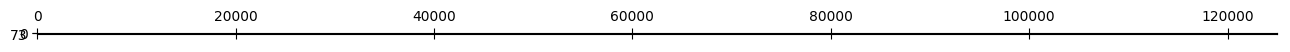

In [37]:
plt.matshow(A)
plt.yticks([0, length(cages)-1])
plt.tight_layout()
plt.savefig("data_matrix_viz.png", format="png", dpi=300, bbox_inches="tight")

How many columns are all zeros?

In [38]:
sum(sum(abs.(A), dims=1) .== 0.0)

84065

In [39]:
rank(A)

73

Perform the SVD decomposition of the data matrix

In [40]:
UΣVᵀ = svd(A)

println("size of U: ", size(UΣVᵀ.U))
println("# singular values: ", length(UΣVᵀ.S))
println("size of Vᵀ: ", size(UΣVᵀ.Vt))

@assert(isapprox(A, UΣVᵀ.U * diagm(0 => UΣVᵀ.S) * UΣVᵀ.Vt))

size of U: (74, 74)
# singular values: 74
size of Vᵀ: (74, 125000)


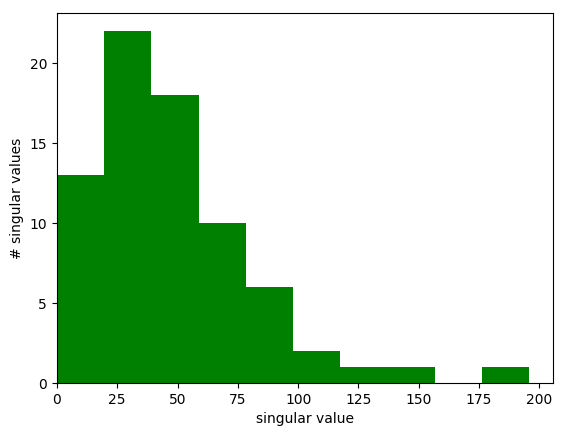

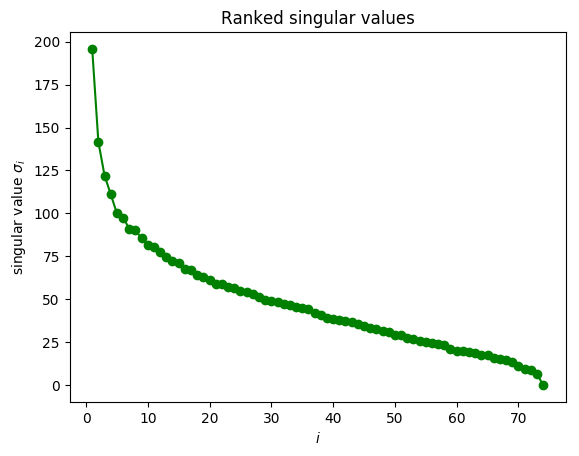

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[41]:2
└ @ Core In[41]:2


In [41]:
plt.figure()
plt.plt[:hist](UΣVᵀ.S, color="g")
plt.xlabel("singular value")
plt.ylabel("# singular values")
plt.xlim(xmin=0)
plt.savefig("distn_of_svs.png", format="png", dpi=300)

plt.figure()
plt.plot(1:length(UΣVᵀ.S), UΣVᵀ.S, color="g", marker="o")
plt.xlabel("\$i\$")
plt.ylabel("singular value \$\\sigma_i\$")
plt.title("Ranked singular values")
plt.savefig("svs_ordered.png", format="png", dpi=300)

ratio of norm of error to norm of $A$.
See pg. 19 of 
> A Singularly Valuable Decomposition: The SVD of a Matrix. Dan Kalman

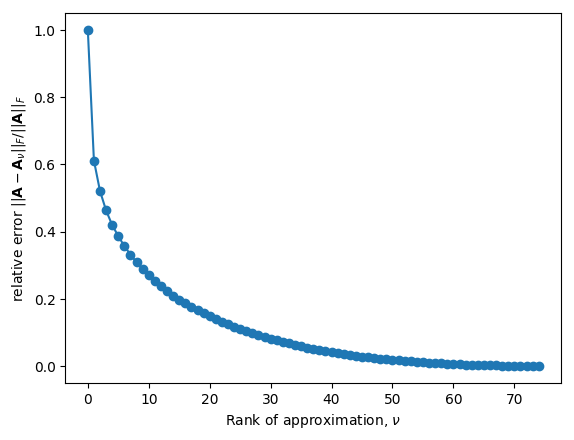

In [42]:
relative_err = 1.0 .- sqrt.([sum(UΣVᵀ.S[1:i] .^ 2) for i = 1:length(UΣVᵀ.S)] / sum(UΣVᵀ.S .^ 2))
relative_err = vcat([1.0], relative_err)

fig = plt.figure()
plt.xlabel("Rank of approximation, \$\\nu\$")
plt.ylabel("relative error \$||\\mathbf{A}-\\mathbf{A}_\\nu||_F/||\\mathbf{A}||_F \$")
plt.plot(0:length(UΣVᵀ.S), relative_err, marker="o")
plt.savefig("relative_err_with_svs.png", format="png", dpi=300)

Take the latent space as a composition of the first `r` singular vectors.
Select `r` so that we recover a certain fraction of the energy, `fraction_energy_recovered`.

In [43]:
# assert singular values are sorted
@assert(sortperm(UΣVᵀ.S) == reverse([i for i = 1:length(UΣVᵀ.S)]))

desired_relative_err = 0.15
ν = findfirst(relative_err .< desired_relative_err) # number of singular values to include

printstyled(@sprintf("%d singular values results in relative error %f; setting latent dim = %d.\n",
    ν, relative_err[ν], ν), color=:red)

x_latent = UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν])
@assert(isapprox(x_latent, A * UΣVᵀ.V[:, 1:ν]), "UΣ != AV")
@assert(size(x_latent) == (length(cages), ν))

21 singular values results in relative error 0.147326; setting latent dim = 21.


use t-SNE to embed latent representation in 2D

In [44]:
Random.seed!(1234)
x_tsne = tsne(x_latent, 2, 0, 100000, 5.0);
size(x_tsne)

┌ Warning: implicit `dims=2` argument now has to be passed explicitly to specify that distances between columns should be computed
│   caller = ip:0x0
└ @ Core :-1
Computing t-SNE  3%|█                                   |  ETA: 0:00:04

Computing t-SNE  9%|███▎                                |  ETA: 0:00:03

Computing t-SNE 14%|████▉                               |  ETA: 0:00:02

Computing t-SNE 18%|██████▌                             |  ETA: 0:00:02

Computing t-SNE 23%|████████▎                           |  ETA: 0:00:02

Computing t-SNE 28%|██████████                          |  ETA: 0:00:02

Computing t-SNE 33%|███████████▊                        |  ETA: 0:00:02

Computing t-SNE 38%|█████████████▋                      |  ETA: 0:00:01

Computing t-SNE 43%|███████████████▎                    |  ETA: 0:00:01

Computing t-SNE 48%|█████████████████▏                  |  ETA: 0:00:01

Computing t-SNE 53%|██████████████████▉                 |  ETA: 0:00:01

Computing t-SNE 58%|█████████████

(74, 2)

write 2D t-SNE latent dim to file for D3 interactive viz

In [45]:
latent_dim_file = open("latent_dim.csv", "w")
@printf(latent_dim_file, "cage_image,x1,x2\n")
for (c, cage) in enumerate(cages)
    @printf(latent_dim_file, "%s_aligned.png,%f,%f\n", cage, x_tsne[c, :]...)
end
close(latent_dim_file)

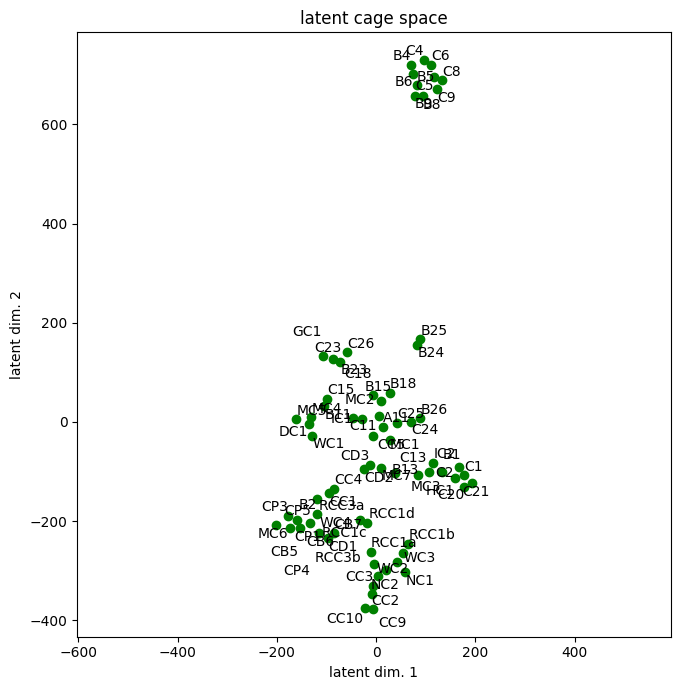

In [46]:
plt.figure(figsize=(7, 7))
plt.scatter(x_tsne[:, 1], x_tsne[:, 2], color="g")
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
texts = []
for i = 1:length(cages)
    push!(texts,
        plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
plt.xlabel("latent dim. 1")
plt.ylabel("latent dim. 2")
plt.axis("equal")
plt.title("latent cage space")
plt.tight_layout()
plt.savefig("latent_cage_space_2D.pdf", format="pdf", dpi=300)
plt.show()

... t-SNE to embed in 3D

Computing t-SNE 40%|██████████████▌                     |  ETA: 0:00:00


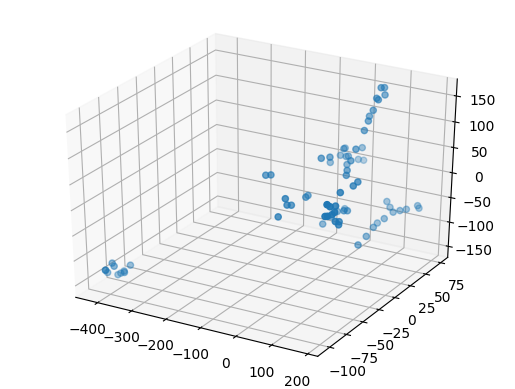


Computing t-SNE 85%|██████████████████████████████▊     |  ETA: 0:00:00

Computing t-SNE100%|████████████████████████████████████| Time: 0:00:00
  KL_divergence:  0.2801


In [48]:
x_tsne_3D = tsne(x_latent, 3, 0, 10000, 5.0);

plt.figure()
plt.scatter3D(x_tsne_3D[:, 1], x_tsne_3D[:, 2], x_tsne_3D[:, 3])
plt.show()

## Correlation between latent space and cage descriptors from `pywindow`

Crude cage size descriptors:

* `molecule_diameter`: if we could stuff the cage molecule into a sphere, how big would the sphere need to be?
* `void_diameter`: distance between center of mass of the molecule and the closest atom, corrected for appropriate vdW radii and multiplied by 2.

See:

> M. Miklitz, S. Jiang, R. Clowes, M. E. Briggs, A. I. Cooper and K. E. Jelfs, Computational Screening of Porous Organic Molecules for Xenon/Krypton Separation, J. Phys. Chem. C, 2017, 121, 15211–15222.

We computed these from `pywindow`:

> M. Miklitz, K. E. Jelfs. pywindow: Automated Structural Analysis of Molecular Pores. ChemRxiv.

(checked WC3 in Table 1 for correspondence of those we computed.) See `cage_descriptors.ipynb`.

In [62]:
types = Dict("window2"=>Union{Float64, Missing, BigInt})
df_descriptors = CSV.read("pywindow_cage_descriptors.csv", types=types)
first(df_descriptors, size(df_descriptors, 2))

,cage,molecule_diameter_A,pore_diameter_A,nb_windows,window1,window2,window3
,String,Float64,Float64,Int64,Float64,String,Float64⍰
1,A11,20.2317,10.7757,4,6.48683,6.495351,6.51591
2,B11,20.9082,6.2361,4,6.90618,6.457134,6.46145
3,B13,24.7109,3.41111,4,2.8832,2.187300,1.18898
4,B15,25.3523,9.82189,4,8.9416,7.952206,8.29333
5,B18,28.0574,11.4157,4,9.80473,10.543764,9.76416
6,B1,15.1623,2.06203,3,2.29784,2.276796,2.28051
7,B23,22.2916,9.48627,6,4.69585,4.722788,4.94502
8,B24,25.0454,8.62108,6,5.90007,6.582749,6.42258
9,B25,29.486,11.5133,6,8.05683,7.675094,7.22764


Put in an array with same order as `cages` for easy plotting

In [64]:
pore_diameters = zeros(length(cages))
molecule_diameters = zeros(length(cages))
nb_windows = zeros(Int, length(cages))
for (i, cage) in enumerate(cages)
    idx_this_cage = df_descriptors[!, :cage] .== cage
    @assert(sum(idx_this_cage) == 1, @sprintf("%s not found in df_descriptors (or multiple)!", cage))
    pore_diameters[i] = df_descriptors[idx_this_cage, :pore_diameter_A][1]
    molecule_diameters[i] = df_descriptors[idx_this_cage, :molecule_diameter_A][1]
    nb_windows[i] = df_descriptors[idx_this_cage, :nb_windows][1]
end

Visualize distribution of descriptors among the cages.

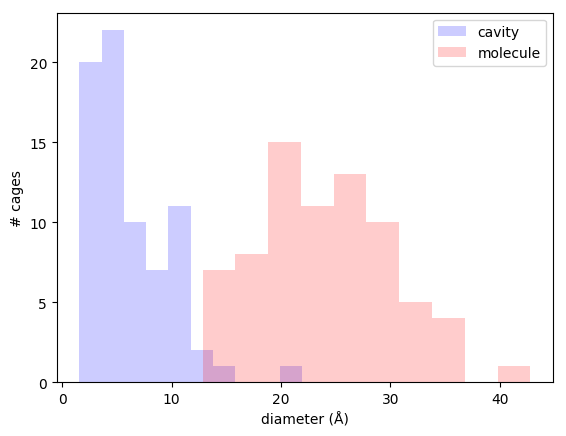

In [66]:
plt.figure()
plt.hist(pore_diameters, color="b", alpha=0.2, label="cavity")
plt.hist(molecule_diameters, color="r", alpha=0.2, label="molecule")
plt.legend()
plt.xlabel("diameter (Å)")
plt.ylabel("# cages")
plt.savefig("pywindow_descriptors_distn.png", format="png", dpi=300)

Visualize distribution of the number of windows

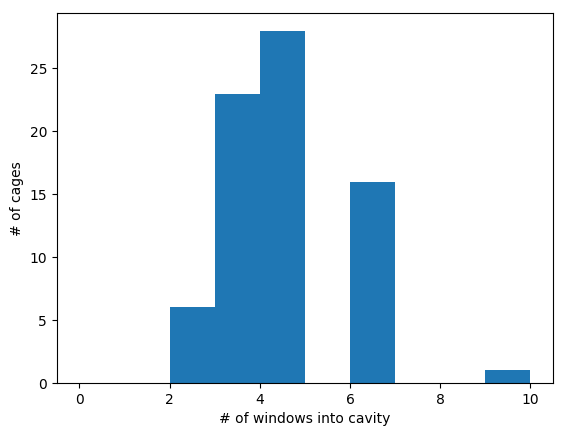

PyObject Text(24.000000000000007, 0.5, '# of cages')

In [68]:
fig = plt.figure()
plt.hist(nb_windows, bins=0:10)
plt.xlabel("# of windows into cavity")
plt.ylabel("# of cages")

Assess if clustering picks on up the descriptors.
Color according to pore diameters, make size according to molecule diameter.
the marker size is the area, so we should make the size on the order of `molecule_diameter^2`.

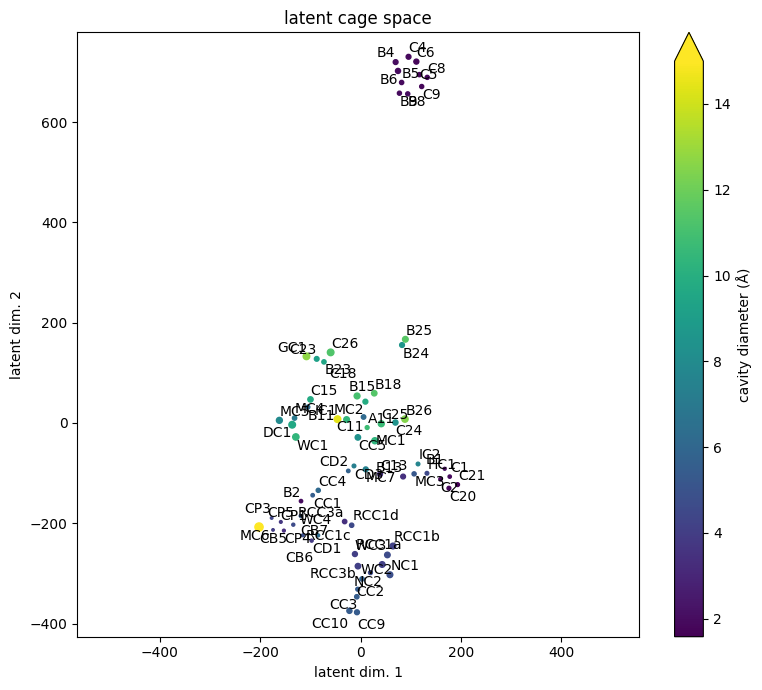

In [70]:
plt.figure(figsize=(8, 7))
plt.scatter(x_tsne[:, 1], x_tsne[:, 2],
    c=pore_diameters,
    s=molecule_diameters .^ 2 / maximum(molecule_diameters .^ 2) * 35.0,
    vmax=15.0
)
texts = []
for i = 1:length(cages)
    push!(texts,
        plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
cbar = plt.colorbar(extend="max", label="cavity diameter (Å)")
plt.title("latent cage space")
plt.xlabel("latent dim. 1")
plt.ylabel("latent dim. 2")
plt.axis("equal")
plt.tight_layout()
plt.savefig("cage_space_colored_by_diams_2D.png", format="png", dpi=300)
plt.show()

hypothesis that first eigencage picks up the pore size.

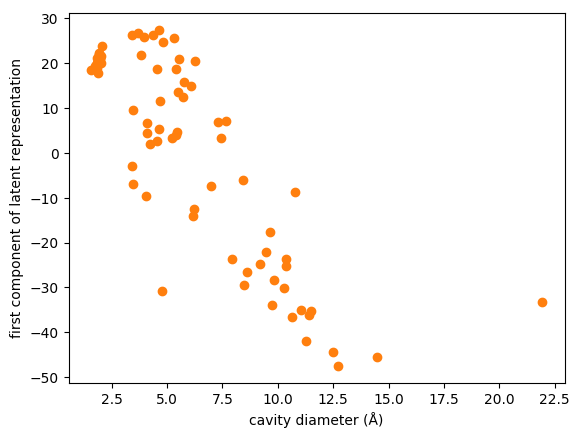

In [72]:
fig = plt.figure()
plt.scatter(pore_diameters, UΣVᵀ.U[:, 1] * UΣVᵀ.S[1], color="C1")
plt.xlabel("cavity diameter (Å)")
plt.ylabel("first component of latent representation")
plt.savefig("first_component_captures_pore_diameter.pdf", format="pdf")

Assess if clustering picks up on # windows 

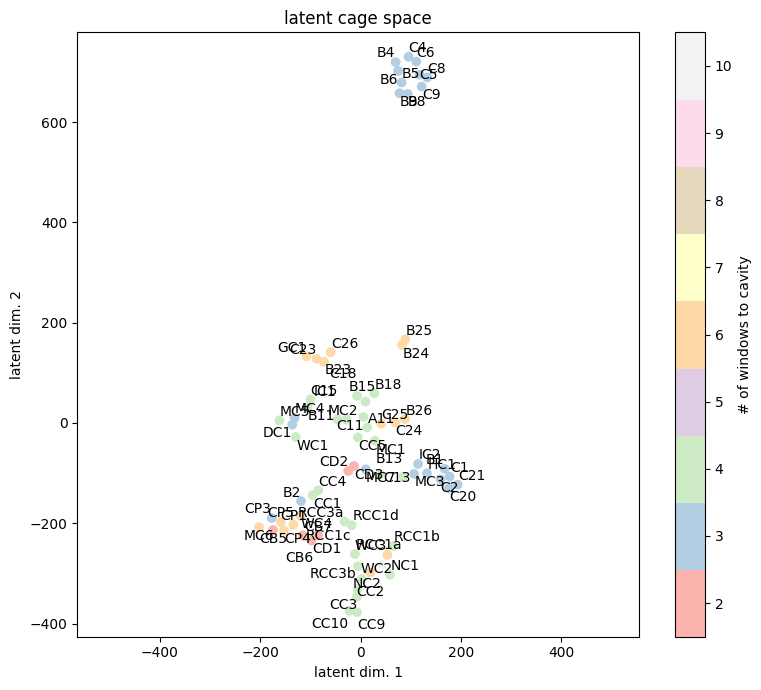

In [73]:
cmap = plt.get_cmap("Pastel1", maximum(nb_windows) - minimum(nb_windows)+1)

plt.figure(figsize=(8, 7))
plt.scatter(x_tsne[:, 1], x_tsne[:, 2],
    c=nb_windows, cmap=cmap, vmin=minimum(nb_windows)-0.5, vmax=maximum(nb_windows)+0.5
)
texts = []
for i = 1:length(cages)
    push!(texts,
        plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
#cbar = plt.colorbar(extend="max", label="cavity diameter (Å)")
plt.title("latent cage space")
plt.xlabel("latent dim. 1")
plt.ylabel("latent dim. 2")
plt.axis("equal")
plt.colorbar(label="# of windows to cavity")
plt.tight_layout()
plt.savefig("cage_space_colored_by_nb_windows.png", format="png", dpi=300)
plt.show()

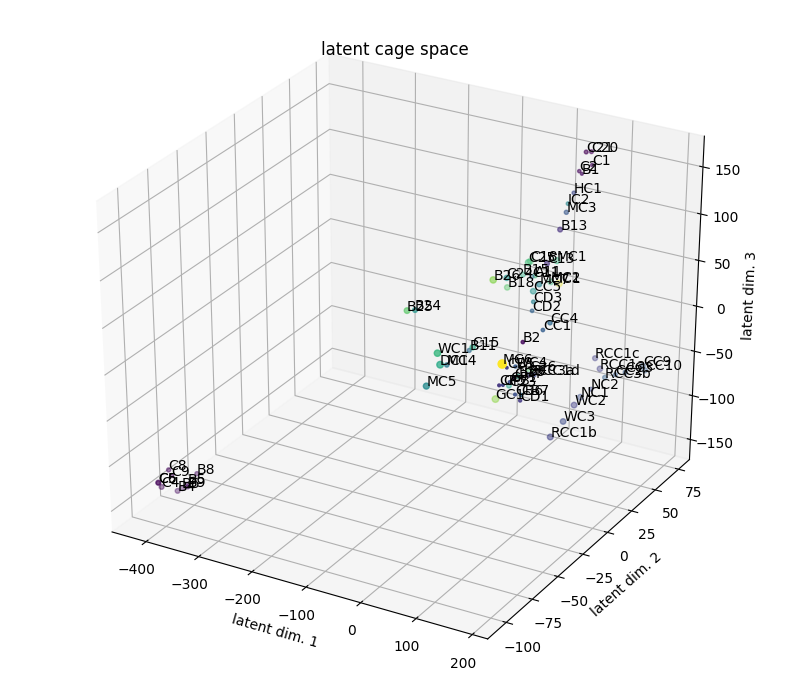

In [74]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(x_tsne_3D[:, 1], x_tsne_3D[:, 2], x_tsne_3D[:, 3],
    c=pore_diameters,
    s=molecule_diameters .^ 2 / maximum(molecule_diameters .^ 2) * 35.0,
    vmax=15.0)
for i = 1:length(cages)
    ax.text(x_tsne_3D[i, 1], x_tsne_3D[i, 2], x_tsne_3D[i, 3], cages[i])
end
plt.xlabel("latent dim. 1")
plt.ylabel("latent dim. 2")
plt.zlabel("latent dim. 3")
plt.title("latent cage space")
plt.tight_layout()
plt.savefig("cage_space_colored_by_diams_3D.png", format="png", dpi=300)
plt.show()

### Visualize the eigen-cages
i.e. discovered concepts, which are the rows of $\mathbf{V}^T$.

In [75]:
for concept_id = 1:ν
    x_concept = transpose(UΣVᵀ.V)[concept_id, :] # flattened
    x_concept = reshape(x_concept, (nb_grid_pts, nb_grid_pts, nb_grid_pts))

    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                reshape(x_concept, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
                :accessibility, -center_of_box)

    write_cube(grid, @sprintf("eigencage%d.cube", concept_id))
end

	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/eigencage1.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/eigencage2.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/eigencage3.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/eigencage4.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/eigencage5.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/eigencage6.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/eigencage7.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/eigencage8.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/eigencage9.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/eigencage10.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/eigencage11.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/

### reconstruct a material as singular values are added

In [76]:
which_cage = "B25"
cage_id = findfirst(cages .== which_cage)

for sv = 1:14
    # approximate matrix
    A_ν = UΣVᵀ.U[:, 1:sv] * diagm(0 => UΣVᵀ.S[1:sv]) * transpose(UΣVᵀ.V[:, 1:sv])
    # reconstruction
    x = A_ν[cage_id, :] .+ average_cage
    
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
            reshape(x, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
            :accessibility, -center_of_box)

    write_cube(grid, @sprintf("%s_reconstructed_%dsvs.cube", which_cage, sv))
end

	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/B25_reconstructed_1svs.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/B25_reconstructed_2svs.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/B25_reconstructed_3svs.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/B25_reconstructed_4svs.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/B25_reconstructed_5svs.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/B25_reconstructed_6svs.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/B25_reconstructed_7svs.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/B25_reconstructed_8svs.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/B25_reconstructed_9svs.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/B25_reconstructed_10svs.cube
	See /home/sturlusa/my_projec

### Compare latent space with Henry coefficients
From Melanie: UFF, 14 A cutoff, geometric mixing rules, 298.0 K

In [77]:
dfs = Dict{String, DataFrame}()
for gas in ["He", "Kr", "Xe"]
    dfs[gas] = CSV.read("henry_coefs/" * gas * "_cage_KH.csv")
end
dfs["He"]

,cage,KH_mol/(m³-bar),KH_mmol/(g-bar),KH_mmol/(kg-Pa),err_KH_mmol/(g-bar)
,String,Float64,Float64,Float64,Float64
1,A11_aligned.cif,40.289,1.86594,1.86594e-5,4.89849e-5
2,B11_aligned.cif,40.2448,1.68872,1.68872e-5,0.000113633
3,B13_aligned.cif,40.1685,1.45798,1.45798e-5,4.91375e-5
4,B15_aligned.cif,40.274,1.90037,1.90037e-5,8.76876e-5
5,B18_aligned.cif,40.2729,1.7852,1.7852e-5,2.49113e-5
6,B1_aligned.cif,40.2332,2.56431,2.56431e-5,0.000107504
7,B23_aligned.cif,40.2413,1.50651,1.50651e-5,3.43654e-5
8,B24_aligned.cif,40.2658,1.48899,1.48899e-5,7.05684e-5
9,B25_aligned.cif,40.2713,1.72822,1.72822e-5,2.29469e-5


In [84]:
df_new = DataFrame(cage=String[], KH_Xe=Float64[], KH_Kr=Float64[])
for row in eachrow(dfs["Xe"])
    kh_he = dfs["He"][dfs["He"][!, :cage] .== row[:cage], 
        Symbol("KH_mol/(m³-bar)")][1]
    kh_kr = dfs["Kr"][dfs["Kr"][!, :cage] .== row[:cage], 
        Symbol("KH_mol/(m³-bar)")][1]
    push!(df_new, [row[:cage], row[Symbol("KH_mol/(m³-bar)")] - kh_he, kh_kr - kh_he])
end
df_new[!, :Xe_Kr_selectivity] = df_new[!, :KH_Xe] ./ df_new[!, :KH_Kr]
first(df_new, 6)

,cage,KH_Xe,KH_Kr,Xe_Kr_selectivity
,String,Float64,Float64,Float64
1,A11_aligned.cif,22.36,8.23432,2.71546
2,B11_aligned.cif,25.9486,9.26889,2.79953
3,B13_aligned.cif,31.2259,10.4816,2.97912
4,B15_aligned.cif,18.3896,7.31678,2.51334
5,B18_aligned.cif,17.795,7.29464,2.43946
6,B1_aligned.cif,11.2393,4.50156,2.49677


In [85]:
S_Xe_kr = [df_new[df_new[!, :cage] .== cage * "_aligned.cif", 
        :Xe_Kr_selectivity][1] for cage in cages][:]

74-element Array{Float64,1}:
  2.7154568539897412
  2.7995337803722045
  2.9791219953211616
  2.513344604257898 
  2.439458412871356 
  2.4967652715248176
  3.5766384932529087
  3.1119506536266366
  2.2863902208987827
  2.4698590751060863
  2.553681089904987 
  2.4814698047387265
  2.5829960732811226
  ⋮                 
 18.591580670038077 
 15.423766898019501 
  2.478360925952521 
  3.05859620212241  
  5.178701517299147 
  7.279271411447992 
  6.557558869300938 
 12.972085114857036 
  2.3915163369019736
 12.76763310069456  
 20.391775643643673 
 30.759371693662313 

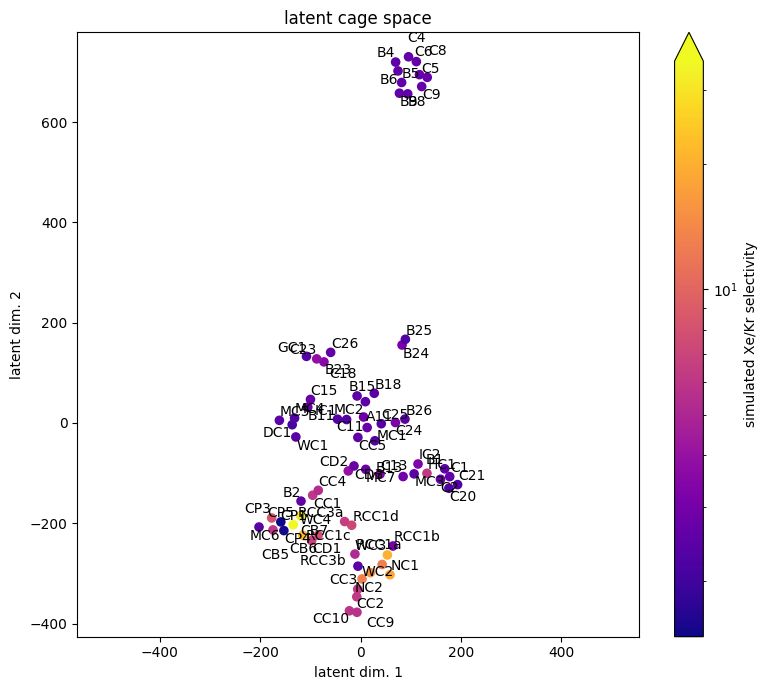

In [89]:
plt.figure(figsize=(8, 7))
plt.scatter(x_tsne[:, 1], x_tsne[:, 2],
    s=35,
    c=S_Xe_kr,
    norm=PyPlot.matplotlib.colors.LogNorm(),
    cmap="plasma"
)
texts = []
for i = 1:length(cages)
    push!(texts,
        plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
cbar = plt.colorbar(extend="max", label="simulated Xe/Kr selectivity")
plt.title("latent cage space")
plt.xlabel("latent dim. 1")
plt.ylabel("latent dim. 2")
plt.axis("equal")
plt.tight_layout()
plt.savefig("cage_space_colored_by_S_Xe_Kr.png", format="png", dpi=300)
plt.show()

Compare Henry coefficients to experimental data for noria and CC3

Noria data from: 10.1002/chem.201602131
CC3 data from: Fig 2c of DOI 10.1038/nmat4035 (plot digitized, sorry for noise; it is on a log scale)

In [90]:
df_expt = Dict("noria" => Dict("Xe" => CSV.read("noria/Xe_expt_298K.csv"),
                               "Kr" => CSV.read("noria/Kr_expt_298K.csv")
                               ),
               "CC3"   => Dict("Xe" => CSV.read("cc3/Xe_expt_298K.csv"),
                               "Kr" => CSV.read("cc3/Kr_expt_298K.csv")
                               )
               )

Dict{String,Dict{String,DataFrame}} with 2 entries:
  "CC3"   => Dict("Kr"=>20×2 DataFrame…
  "noria" => Dict("Kr"=>22×2 DataFrame…

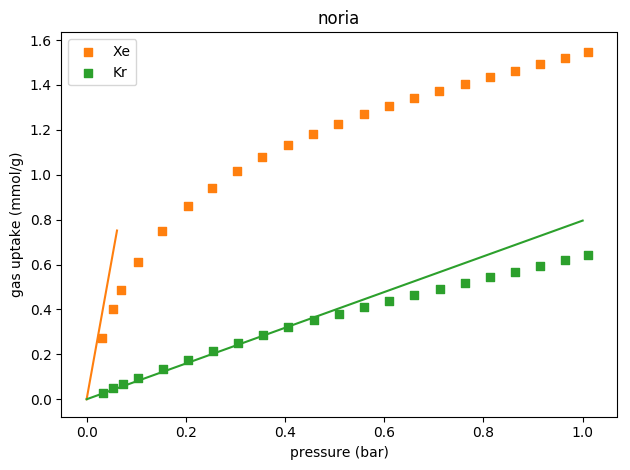

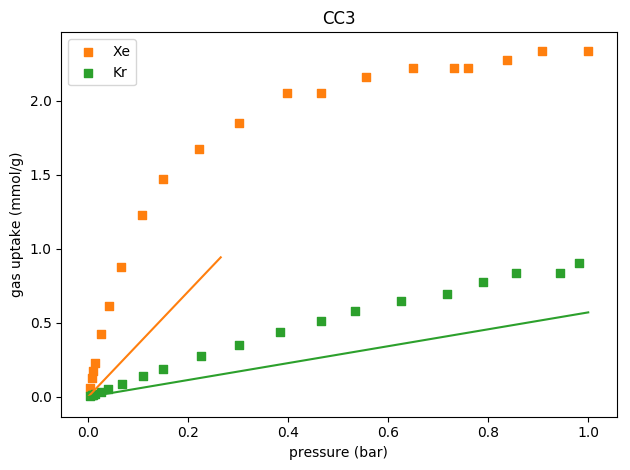

In [97]:
gas_colorz = Dict("Xe" => "C1", "Kr" => "C2")
markerz = Dict("Xe" => "s", "Kr" => "s")
xtal_name = Dict("noria" => "NC2_aligned.cif", "CC3" => "CC3_aligned.cif")

for cage in ["noria", "CC3"]
    fig = plt.figure()
    plt.xlabel("pressure (bar)")
    plt.ylabel("gas uptake (mmol/g)")
    
    P = collect(range(0, stop=1, length=50))
    KH_He =  dfs["He"][dfs["He"][!, :cage] .== xtal_name[cage], Symbol("KH_mmol/(g-bar)")][1]
    for gas in ["Xe", "Kr"]
        # plot experimental data
        if cage == "noria"
            df_expt[cage][gas][!, Symbol("P(bar)")] = df_expt[cage][gas][!, Symbol("P(torr)")] * 0.00133322
        end
        plt.scatter(df_expt[cage][gas][!, Symbol("P(bar)")], 
                    df_expt[cage][gas][!, Symbol("L(mmol/g)")], label=gas,
                    color=gas_colorz[gas], marker=markerz[gas])
        
        # grab simulated henry coeff and plot resulting henry's law
        KH =  dfs[gas][dfs[gas][!, :cage] .== xtal_name[cage], Symbol("KH_mmol/(g-bar)")][1]
        nH = (KH - KH_He) * P
        idx_keep = nH .< 1.0
        plt.plot(P[idx_keep], nH[idx_keep], color=gas_colorz[gas])
    end
    plt.title(cage)
    plt.legend()
    plt.tight_layout()
    plt.savefig(cage * "_expt_sim_comparison.png", format="png")
end

## A walk through latent space

In [98]:
cage_i = "DC1"
cage_j = "CC9"

idx_i = findfirst(cages[:] .== cage_i)
idx_j = findfirst(cages[:] .== cage_j)

x_latent_i = (UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν]))[idx_i, :]
x_latent_j = (UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν]))[idx_j, :]
# c is interpreting parameter
for c in 0.0:0.2:1.0
    x_latent_fictitious = c * x_latent_i + (1 - c) * x_latent_j
    x_fictitious = x_latent_fictitious' * UΣVᵀ.V[:, 1:ν]'
    x_fictitious = x_fictitious' # back to column vector
    # add average cage
    x_fictitious = x_fictitious + average_cage
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
               reshape(x_fictitious, (nb_grid_pts, nb_grid_pts, nb_grid_pts)),
               :accessibility, -center_of_box)
    write_cube(grid, @sprintf("%s_%s_interpolation_c_%.2f.cube", cage_i, cage_j, c))
end

	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/DC1_CC9_interpolation_c_0.00.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/DC1_CC9_interpolation_c_0.20.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/DC1_CC9_interpolation_c_0.40.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/DC1_CC9_interpolation_c_0.60.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/DC1_CC9_interpolation_c_0.80.cube
	See /home/sturlusa/my_projects/scratch/latent_cage_space/data/grids/DC1_CC9_interpolation_c_1.00.cube


## Radar plots 
(cool was to visualize a high-dimensional representation but not used in the paper)

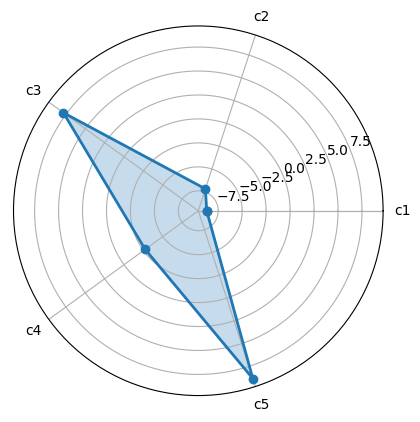

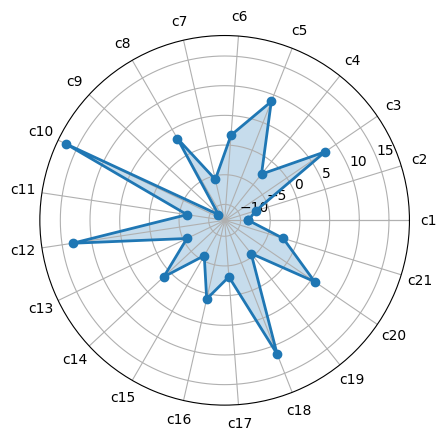

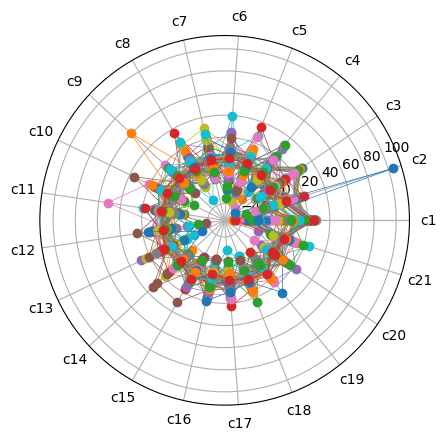

┌ Warning: think this might beed to be transpose
└ @ Main In[100]:33


In [100]:
function draw_radar_plot(x::Array{Float64, 1})
    n_dims = length(x)
    angles = range(0, stop = 2 * π, length = n_dims + 1)[1:end-1]
    # make periodic
    x = vcat(x, [x[1]])
    angles = vcat(angles, [angles[1]])
    labels = ["c$i" for i = 1:n_dims]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=true)
    ax.grid(true)
    ax.set_thetagrids(angles * 180.0 / π, labels)  # Set the label for each axis
    ax.plot(angles, x, "-o", linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax.fill(angles, x, alpha=0.25)  #Fulfill the area
end

function draw_radar_plot(x::Array{Float64, 2})
    n_dims = size(x)[2]
    angles = range(0, stop = 2 * π, length = n_dims + 1)[1:end-1]
    # make periodic
    angles = vcat(angles, [angles[1]])
    labels = ["c$i" for i = 1:n_dims]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=true)
    ax.grid(true)
    ax.set_thetagrids(angles * 180.0 / π, labels)  # Set the label for each axis
    for i = 1:size(x)[1]
        x_viz = vcat(x[i, :], [x[i, 1]])
        ax.plot(angles, x_viz, "-o", linewidth=0.5)  # Draw the plot (or the frame on the radar chart)
        # ax[:fill](angles, x_viz, alpha=0.25)  #Fulfill the area
    end
    @warn "think this might beed to be transpose"
end

draw_radar_plot(x_latent[1, 1:5])
draw_radar_plot(x_latent[1, :])
draw_radar_plot(x_latent)
#ax.set_rlim(0,250)